# IMAPAIN - Resting-State-Analysis-Script

This Notebook analyses the Resting-State-fMRI of the IMAGEN-Project regarding its association with pain conditions. 
As written in **include Paper** the data beforehand have been pre-processed FMRIprep and denoised using fmriDenoise.

The Notebook consists of following chapters:
   1. Import of behavioral data
   2. Import and prepare First-Level-Analysis
   3. Second Level Analysis
   4. Plots
   
**Please notice:** This notebook is performing highly computationally labourious operations. Therefore it is designed to be partly run on a HPC. See ´Usage on HPC´ for detail

***
Python-Modules used:
*pandas*, *numpy*, *nibabel*, *os*, *scipy*, *nilearn*, *dill*, *seaborn*

In [1]:
# basic file operations
import os
import dill

# Data Handling and mathematical Operations
import numpy as np
import pandas as pd
from scipy.stats import zscore

# Neuroimaging and Connectome
from nibabel import load as load_img
from nilearn.input_data import NiftiMapsMasker
from nilearn.datasets import fetch_atlas_difumo
from nilearn.connectome import ConnectivityMeasure
from nilearn.image import index_img
from nilearn.image import resample_to_img
from nilearn.connectome import sym_matrix_to_vec
from nilearn.connectome import vec_to_sym_matrix

# Statistics
from scipy.stats import ttest_rel
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.multitest import multipletests

# Visualization
from mne.viz import plot_connectivity_circle
from mne.viz import circular_layout
from seaborn import violinplot
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import pyplot, colors
from mpl_toolkits.mplot3d import Axes3D
from nilearn import plotting

/gxfs_home/cau/suknp018/miniconda3/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


**Usage on HPC**

This Script offers multiple modes. Especially for First-Level-Analysis I highly recommend running via slurm jobs on an HPC. To do so change the First_Level and HPC Flag to True, export the notebook as Python-Script. Execute the Script as Parallel jobs with every Job running one subject. Therefore the number of the Job must be given as argument when running the python executable. The slurm job batch used can be found at the end of the Notebook.

In [2]:
First_Level = False      # make True if running First-Level-Analysis -> will exit after First-Level Analysis has been computed!!!
Second_Level = True    # make True if running Second-Level-Analysis
HPC = True    # make true if running via multiple jobs on HPC

Next Cell is in `raw` so that it just gets used if the notebook is exported as executable and run via a SLURM job 

 ***
## Import of behavioral data
This chapter imports BIDS-confom behavioral data and transorms it in a workable df

### Basic Constants
***
define the directory to the behavioral and neuroimaging data

In [3]:
basicdirectory = "/gxfs_work1/cau/suknp018/My_Data/IMAGEN/data"
base = "/gxfs_work1/cau/suknp018/My_Data/"

In [4]:
timepoints = ['FU2', 'FU3']

### Functions
---
***extract_folder_names***  
Function to get a list of all subdirectories and files in a directory

In [5]:
def extract_folder_names(Path):
    listoffolders = os.listdir(str(Path))
    return listoffolders

***add_column_to_dataframe*** 
extracts single column out of a dataframe and adds it to another datafram while keeping attention on the index (e.g. vp-code)

In [6]:
def add_column_to_dataframe(sourcedf, destinationdf, sourcecol, destinationcol): # sourcedf needs to have column "participant_id" as defined in BIDS
    destinationdf.loc[:, destinationcol] = np.nan
    for x in destinationdf.index:
        if x in sourcedf.index: 
            destinationdf.loc[x, destinationcol] = sourcedf.loc[x, sourcecol]
    return destinationdf

***z-transform***

In [7]:
def z_transform(dataframe, column):
    dataframe.loc[:, column] = zscore(dataframe.loc[:, column], nan_policy= 'omit')


***add_sum_score***

In [8]:
def add_sum_score(questionnaire_df, col_list, sum_name):
    questionnaire_df.loc[:, sum_name] = questionnaire_df[col_list].sum(axis=1, skipna = True)

### Import behavioral data
***

In [9]:
participants = pd.read_csv(basicdirectory + "/participants.tsv", sep="\t", index_col='participant_id')
CSI_FU1 = pd.read_csv(basicdirectory + "/phenotype/" + "CSI_CHILD_FU.tsv", sep="\t", index_col='participant_id')
CSI_FU2 = pd.read_csv(basicdirectory + "/phenotype/" + "CSI_CHILD_FU2.tsv", sep="\t", index_col='participant_id')
CSI_FU3 = pd.read_csv(basicdirectory + "/phenotype/" + "CSI_FU3.tsv", sep="\t", index_col='participant_id')

age_FU2 = pd.read_csv(basicdirectory + "/phenotype/" + "IMAGEN_dawba_FU2.tsv", sep="\t", index_col=0, usecols=[0,1], dtype=str)
age_FU3 = pd.read_csv(basicdirectory + "/phenotype/" + "IMAGEN_dawba_FU3.tsv", sep="\t", index_col=0, usecols=[0,1], dtype=str)

***
### Metadataframe 
Make a dataframe, which shows for which participant there are what kind of data

***Pain-Questionnaires*** Did the VP complete at least one questionnaire?

In [10]:
participants["CSI_FU1"]= np.nan
participants["CSI_FU2"]= np.nan
participants["CSI_FU3"]= np.nan

In [11]:
for x in participants.index:
    if x in CSI_FU1.index:
        participants.loc[x, 'CSI_FU1'] = True
    if x in CSI_FU2.index:
        participants.loc[x, 'CSI_FU2'] = True  
    if x in CSI_FU3.index:
        participants.loc[x, 'CSI_FU3'] = True

***Resting-State-Imaging*** 

Check for preprocessed fMRI-RS-Data

In [12]:
participants["Rest_FU2"] = np.nan
participants["Rest_FU3"] = np.nan

In [13]:
for sub, idx in zip(participants.index, range(len(participants.index))):
    for time in timepoints:
        if os.path.isfile(base + "IMAGEN_" + time + 
                          "/data/derivatives/fmriprep/" +
                          sub + "/ses-" + time + "/func/" +
                          sub + "_ses-" + time + 
                          "_task-rest_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"):
            participants.loc[sub, str('Rest_' + time)] = True
        else:
            print(sub + ' number ' + str(idx) + ' at ' + time + ' is missing')

# fill nan with False
for i in participants.index:
    for j in participants.columns[2:]:
        if participants.loc[i, j] is not True:
            participants.loc[i, j] = False
            participants.loc[i, j]


sub-000015059321 number 107 at FU2 is missing
sub-000015312177 number 108 at FU2 is missing
sub-000016069129 number 113 at FU2 is missing
sub-000019340307 number 136 at FU2 is missing
sub-000038916315 number 282 at FU2 is missing


**Subdataframe**

Define which participants are usable for further analysises. 
They should have:
1. Neuroimagingdata for FU2 and FU3
2. Questionnaire data for FU2 and FU3

In [14]:
t = []
for i in participants.index:
    if not (participants.loc[i, 'CSI_FU2'] == True and
            participants.loc[i, 'CSI_FU3'] == True and
            participants.loc[i, 'Rest_FU3'] == True and
            participants.loc[i, 'Rest_FU2']): 
        t.append(i)
participants_usable = participants.drop(t)
print(str(participants_usable.shape[0]) +
      ' subjects are usable for this analysis')

690 subjects are usable for this analysis


***
### Questionnaire data

In [15]:
df = participants_usable[['sex', 'recruitment centre']].copy()

In [16]:
# recode sex
for sub in df.index:
    if df.loc[sub, 'sex'] == 'M':
        df.loc[sub, 'sex'] = 1
    else:
        df.loc[sub, 'sex'] = 0
df.loc[:, 'sex'] = df.loc[:, 'sex'].astype('int')

***CSI***

Make Pain/Weakness-sum-score according to **Meester et al (2003)** *https://doi.org/10.1093/jpepsy/jsg031*

Litcher, L., Bromet, E., Carlson, G., Gilbert, T., Panina, N., Golovakha, E., et al. (2001
). Ukrainian application of the Children's Somatization Inventory: Psychometric properties and associations with internalizing symptoms. Journal of Abnormal Child Psychology
, 29
, 165
-175.

In [17]:
pain_score_cols = ['item34', 'item3', 'item12', 'item11',
                   'item33', 'item17', 'item7',
                   'item6', 'item18', 'item9']
for csi in [CSI_FU1, CSI_FU2, CSI_FU3]:
    add_sum_score(csi, pain_score_cols, 'csi_pain_sum')

In [18]:
# Add csi_sum_scores
df = add_column_to_dataframe(CSI_FU1, df, 'csi_sum', 'FU1_csi_sum')
df = add_column_to_dataframe(CSI_FU2, df, 'csi_sum', 'FU2_csi_sum')
df = add_column_to_dataframe(CSI_FU3, df, 'csi_sum', 'FU3_csi_sum')
# csi pain sum
df = add_column_to_dataframe(CSI_FU1, df, 'csi_pain_sum', 'FU1_csi_pain_sum')
df = add_column_to_dataframe(CSI_FU2, df, 'csi_pain_sum', 'FU2_csi_pain_sum')
df = add_column_to_dataframe(CSI_FU3, df, 'csi_pain_sum', 'FU3_csi_pain_sum')

make difference and change scores

In [19]:
# Score difference
# df.loc[:,'csi_pain_diff_12']=df.loc[:,'FU1_csi_pain_sum']-df.loc[:,'FU2_csi_pain_sum']
df.loc[:, 'csi_pain_diff_23'] = (df.loc[:, 'FU2_csi_pain_sum'] - df.loc[:, 'FU3_csi_pain_sum'])
# negative means more symptoms, positive means less

In [20]:
# z-scale everything
for col in ['FU1_csi_pain_sum', 'FU2_csi_pain_sum', 'FU3_csi_pain_sum', 'csi_pain_diff_23']:
    z_transform(df, col)

In [21]:
# add unscaled csi-sums
df = add_column_to_dataframe(CSI_FU2, df, 'csi_pain_sum', 'FU2_csi_pain_sum_raw')
df = add_column_to_dataframe(CSI_FU3, df, 'csi_pain_sum', 'FU3_csi_pain_sum_raw')

In [22]:
df.head()

sex recruitment centre  FU1_csi_sum  FU2_csi_sum  \
participant_id                                                       
sub-000000112288    1              PARIS          3.0          3.0   
sub-000000240546    1             BERLIN          3.0          1.0   
sub-000000308867    1         NOTTINGHAM          9.0          8.0   
sub-000000469693    0            HAMBURG         19.0          9.0   
sub-000000613223    1            DRESDEN          NaN          8.0   

                  FU3_csi_sum  FU1_csi_pain_sum  FU2_csi_pain_sum  \
participant_id                                                      
sub-000000112288          6.0         -0.205672         -0.238478   
sub-000000240546          2.0         -0.910051         -0.826157   
sub-000000308867          2.0          1.203088          0.349201   
sub-000000469693          4.0          0.733501          0.055361   
sub-000000613223          1.0               NaN         -0.826157   

                  FU3_csi_pain_sum  csi_pain_diff_23  FU2_csi_pain_sum_raw  \
participant_id                                                               
sub-000000112288         -0.032431         -0.185322                   2.0   
sub-000000240546         -0.629164         -0.185322                   0.0   
sub-000000308867         -0.629164          0.869296                   4.0   
sub-000000469693         -0.629164          0.605641                   3.0   
sub-000000613223         -0.629164         -0.185322                   0.0   

                  FU3_csi_pain_sum_raw  
participant_id                          
sub-000000112288                   2.0  
sub-000000240546                   0.0  
sub-000000308867                   0.0  
sub-000000469693                   0.0  
sub-000000613223                   0.0

***CANTAB***  (for Age information)

In [23]:
# add sub- to column
index_list = age_FU2.index

index_new = []
for index in index_list:
    index = str('sub-'+index)
    index_new.append(index)
age_FU2.loc[:, 'participants_id'] = index_new
age_FU2.set_index('participants_id', inplace=True)

# add sub- to column
index_list = age_FU3.index

index_new = []
for index in index_list:
    index = str('sub-'+index)
    index_new.append(index)
age_FU3.loc[:, 'participants_id'] = index_new
age_FU3.set_index('participants_id', inplace=True)

In [24]:
df = add_column_to_dataframe(age_FU2, df, 'PSC2', 'FU2_age')
df.loc[:, 'FU2_age'] = df.loc[:, 'FU2_age'].astype('float')

In [25]:
df = add_column_to_dataframe(age_FU3, df, 'PSC2', 'FU3_age')
df.loc[:, 'FU3_age'] = df.loc[:, 'FU3_age'].astype('float')

## Participants

In [26]:
print(str(df.shape[0]) + ' subjects have complete datasets')

690 subjects have complete datasets


In [27]:
print(str(df.loc[:, 'sex'].sum()) + ' males and ' +
      str(df.shape[0] - df.loc[:, 'sex'].sum()) + ' females')

291 males and 399 females


In [28]:
print('The mean age at FU2 is {} and at FU3 {}. The mean time between the two timepoints is {}'
      .format(df.loc[:, 'FU2_age'].mean(), df.loc[:, 'FU3_age'].mean(),
              df.loc[:, 'FU3_age'].subtract(df.loc[:, 'FU2_age']).mean()))

The mean age at FU2 is 18.452830188679247 and at FU3 22.002936857562407. The mean time between the two timepoints is 3.552941176470588


### Pain/Weakness

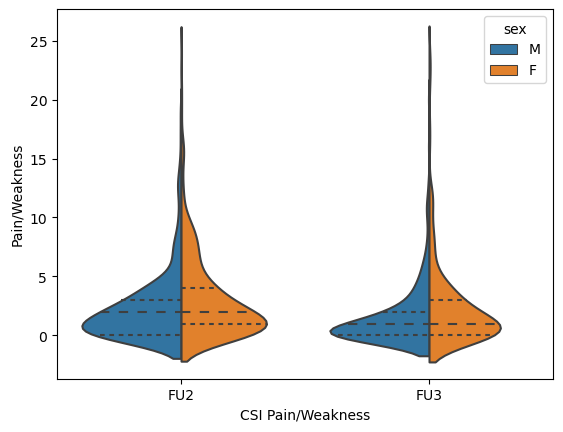

In [29]:
graphical_df = pd.concat([df.loc[:, ['FU2_csi_pain_sum_raw', 'sex']],
                          df.loc[:, ['FU3_csi_pain_sum_raw', 'sex']]],
                         axis=0)
graphical_df.set_axis(['Age 19', 'sex', 'Age 23'], axis=1, inplace=True)

age = []
csi_score =[]

for sub in range(graphical_df.shape[0]):
    if np.isnan(graphical_df.iloc[sub, 0]):
        age.append('FU3')
        csi_score.append(graphical_df.iloc[sub, 2])
    else:
        age.append('FU2')
        csi_score.append(graphical_df.iloc[sub, 0])

graphical_df['Age'] = age
graphical_df['Pain/Weakness'] = csi_score
graphical_df['sex'].replace(1, 'M', inplace=True)
graphical_df['sex'].replace(0, 'F', inplace=True)

boxi = violinplot(data=graphical_df,
                  x='Age', y='Pain/Weakness',
                  inner ="quartile", hue='sex',
                  split= True)
boxi.set_xlabel('CSI Pain/Weakness')
plt.show()

In [30]:
print(df.loc[:, 'FU3_csi_pain_sum']
      .subtract(df.loc[:, 'FU2_csi_pain_sum'])
      .mean())

print(ttest_rel(df.loc[:, 'FU2_csi_pain_sum_raw'], df.loc[:, 'FU3_csi_pain_sum_raw']))

-3.5076611502649876e-17
Ttest_relResult(statistic=4.864493281664551, pvalue=1.42310785905335e-06)


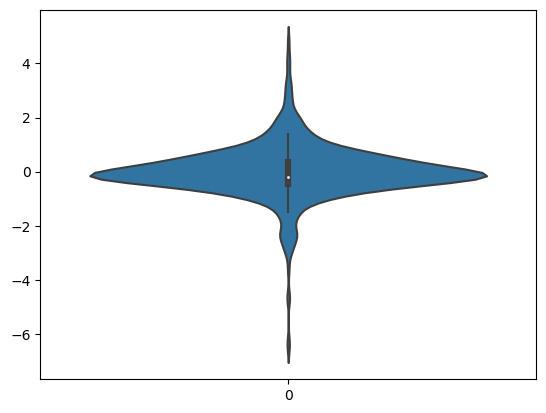

In [31]:
boxi = violinplot(data=df.loc[:, 'csi_pain_diff_23'])
plt.show()

## Import preprocessed and denoised fMRI-data

The Raw data was preprocessed using fMRIPrep and denoised using fMRIDenoise (For Details see Method Section). The following section imports these into the working directory.

In [32]:
if Second_Level is True:
    %matplotlib inline

In [33]:
# Denoising pipeline that has been used by fMRIDenoise
pipelines = ["pipeline-ICAAROMA8Phys"]

In [34]:
def import_fmridenoise_derivatives(time, df, pipeline):    #returns specific Image-Type and sub-ID of HALFpipe Derivate Folder
    image_list = []
    for sub in df.index:
        image_dir = str(base + "IMAGEN_" + time +
                        '/data/derivatives/fmridenoise/ses-' +
                        time + '/' + sub + '/'
                        + sub + '_ses-' + time +
                        '_task-rest_' + pipeline +
                        '_desc-denoised_bold.nii.gz')
        if os.path.isfile(image_dir):
            image_list.append(image_dir)
        else:
            image_list.append('nan')
            print(sub + ' ' + time)
    df.loc[:, str('Denoised_Images_' + pipeline + '_' + time)] = image_list
    return df

In [35]:
for pipeline in pipelines:
    df = import_fmridenoise_derivatives('FU3', df, pipeline)
    df = import_fmridenoise_derivatives('FU2', df, pipeline)

In [36]:
# drop subjects with incomplete data
_ = 0
for pipeline in pipelines:
    for sub in df.index:
        if (not os.path.isfile(df.loc[sub, str('Denoised_Images_' + pipeline + '_FU2')]) or
            not os.path.isfile(df.loc[sub, str('Denoised_Images_' + pipeline+'_FU3')])):
            df.drop(sub, inplace=True)
            _ = _+1
            print(sub + 'excluded')

print(str(str(_)+' subjects excluded due to missing data'))

0 subjects excluded due to missing data


***
### Quality Control

Check if fmriDenoise found subjects which have to be excluded due to standard criteria

In [37]:
subjects_to_exclude_pipelinewise = []  # list with subjects to exclude for each pipeline
for pipeline in pipelines:
    subjects_to_exclude =[]
    for time in timepoints:
        summary = pd.read_csv(str('/gxfs_work1/cau/suknp018/My_Data/IMAGEN_' +
                                  time + '/data/derivatives/fmridenoise/ses-' +
                                  time + '/ses-' + time +
                                  '_task-rest_' + pipeline +
                                  '_groupConfSummary.tsv'),
                              sep='\t', dtype='object')
        for idx in summary.index:
            if summary.loc[idx, 'include'] == 'False':
                subjects_to_exclude.append(str('sub-' +
                                               str(summary.loc[idx, 'subject'])))
    subjects_to_exclude_pipelinewise.append(subjects_to_exclude)

In [38]:
print(str(len(subjects_to_exclude_pipelinewise[0])) +
      ' subjects excluded due to unsatisfying preprocessing/denoising results')

0 subjects excluded due to unsatisfying preprocessing/denoising results


***
## First-Level-Analysis 
Compute subjectwise Connectomes

In [39]:
# make bids-complient directorty for nilearn derivatives
nilearn_dir = str(basicdirectory + '/derivatives/nilearn')
if not os.path.isdir(nilearn_dir):
    os.mkdir(nilearn_dir)

### DiFuMo-Atlas by Dadi et al (2020)
Load **DiFuMo-Atlas** by Dadi et al (2020) *doi:  https://doi.org/10.1016/j.neuroimage.2020.117126*

The DiFuMo Atlas includes the major cortical and subcortical nodes of the human brain. It can therefore be used to reduce the dimensionality of the brain data. We here used the 256-dimension parcellation as this showed best performance in the prediction of behavior scores. (see Dadi 2020)

In [40]:
atlas = fetch_atlas_difumo(dimension=256, resolution_mm=2)
DifuMo_maps = atlas.maps
DifuMo_maps = load_img(DifuMo_maps)

DiFuMo_labels = []
DiFuMo_network_labels = []
for label in atlas.labels:
    DiFuMo_labels.append(label[1]) # anatomical name
    DiFuMo_network_labels.append(label[3]) # networks

DiFuMo_maps_list = []
for idx in range(DifuMo_maps.shape[3]):
    DiFuMo_maps_list.append(index_img(DifuMo_maps, idx))

/gxfs_home/cau/suknp018/miniconda3/lib/python3.9/site-packages/numpy/lib/npyio.py:2405: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


/gxfs_home/cau/suknp018/miniconda3/lib/python3.9/site-packages/nilearn/plotting/displays.py:101: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


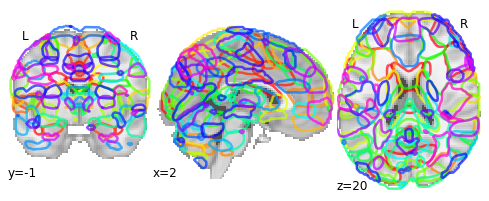

In [41]:
plotting.plot_prob_atlas(DiFuMo_maps_list, draw_cross=False)
plotting.show()

### Young Basal Ganglia Atlas by Keuken et al. (2015)

**Basal-Ganglia Atlas** by Keuken et al (2015) *doi: https://doi.org/10.1016/j.neuroimage.2014.03.032*

Although the DiFuMo-Atlas covers basal ganglia region as most cortical atlasses it is not suitable for detailled analyses of this region as its VOIs are way bigger than important functional and anatomical regions in this particular brain region. Therefore by using the Keuken et al (2015) basal ganglia atlas we included a state-of-the art atlas of this structures. Furthermore the referenced atlas fits to the age of our participants.

In [42]:
roi_maps_keuken=[]
maps2 = os.listdir('/gxfs_work1/cau/suknp018/atlas/Keuken')
maps = []
for idx in range(len(maps2)):
    if 'resampled' not in maps2[idx] and 'non_linear' in maps2[idx]:   # load raw maps 
        maps.append(maps2[idx])

# resample maps if not already done and save them
for atlas_map in maps:
    if not os.path.isfile('/gxfs_work1/cau/suknp018/atlas/Keuken/resampled_to_DiFuMo_' + atlas_map):
        img = load_img('/gxfs_work1/cau/suknp018/atlas/Keuken/' + atlas_map)
        img = resample_to_img(img, DiFuMo_maps_list[0]) # resample maps to fit to DiFuMo-Atlas
        img.to_filename('/gxfs_work1/cau/suknp018/atlas/Keuken/resampled_to_DiFuMo_' + atlas_map)
        roi_maps_keuken.append(img)
    else:
        img = load_img('/gxfs_work1/cau/suknp018/atlas/Keuken/resampled_to_DiFuMo_' + atlas_map)
        roi_maps_keuken.append(img)

roi_names_atlas_keuken = []
roi_networks_keuken = []
for atlas_map in maps:
    name = atlas_map[0:5]
    roi_names_atlas_keuken.append(name)
    roi_networks_keuken.append('Basal Ganglia')

In [43]:
# rename to actual names
roi_names_atlas_keuken = ['Globus Palladius internal LH',
                          'Red Nucleus LH', 'Substantia Nigra LH',
                          'Striatium LH', 'Red Nuucleus RH',
                          'Periaqueductal Gray', 'Substantia Nigra RH',
                          'Subthalamic Nucleus LH', 'Subthalamic Nucleus RH',
                          'Globus Palladius external RH', 'Striatium RH',
                          'Globus Palladius external RH', 'Globus Palladius internal RH']

/gxfs_home/cau/suknp018/miniconda3/lib/python3.9/site-packages/numpy/ma/core.py:2825: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/gxfs_home/cau/suknp018/miniconda3/lib/python3.9/site-packages/nilearn/plotting/displays.py:101: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),


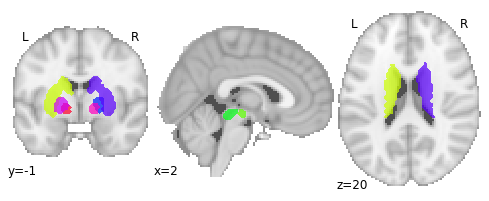

In [44]:
plotting.plot_prob_atlas(roi_maps_keuken, draw_cross=False)
plotting.show()

### Combine both Atlasses
To build individual connectomes based on both atlasses combine these.

In [45]:
atlas_maps_combined = DiFuMo_maps_list + roi_maps_keuken  # maps
atlas_labels_combined = DiFuMo_labels + roi_names_atlas_keuken  # names
atlas_networks_combined = DiFuMo_network_labels + roi_networks_keuken  # networks

### Brain organisation/ Functional Connectomes
Compute the individual correlation matrices. Only compute if not already done and only as slurm jobs on HPC (Highly computational demanding! Needs days if done on individual core)

While doing this smooth with fwhm = 5, apply low and high pass filter as common in FC analysis.
Don't standardize as we also want to compute individual differences between the timepoints, which would be distorted if standardized in advance

***subjectwise_corelation_matrix*** : Computes the subjectwise correlation matrices or loads them into WS if correlation matrix was already computed in advance

In [46]:
def subjectwise_corelation_matrix(df, time, atlas, atlasname, pipeline):
    correlation_matrix_list = []
    atlas_masker = NiftiMapsMasker(maps_img=atlas,
                                              t_r=2,
                                              smoothing_fwhm=5,
                                              low_pass=.1,
                                              high_pass=.01,
                                              memory='nilearn_cache',
                                              verbose=5)  # Make Niftimasker
    for sub in df.index:
        # only compute if denoised nifti exists and not already done 
        if (os.path.isfile(df.loc[sub, str('Denoised_Images_' 
                                          + pipeline + '_' + time)]) and
            not os.path.isfile(str('/gxfs_work1/cau/suknp018/My_Data/IMAGEN/data/derivatives/nilearn/'+
                                   sub + '/ses-' + time +
                                   '/' + sub + '_' + pipeline +
                                   '_' + atlasname + 
                                   '_corrmat-smoothed.tsv'))):
            # first make timeseries for every VOI
            time_series = atlas_masker.fit_transform(df.loc[sub, str("Denoised_Images_" + pipeline + '_' + time)])
            # Choose Correlation Measure
            correlation_measure = ConnectivityMeasure(kind='correlation')
            # Fit Correlation measure to time series of VOIs. The index [0] is necessary as the Masker output is a list with multiple attributes.
            # I don't like that index but it does not work otherwise.
            correlation_matrix = correlation_measure.fit_transform([time_series])[0]
            # Make BIDS-conform folder if not already there
            if not os.path.isdir(str('/gxfs_work1/cau/suknp018/My_Data/IMAGEN/data/derivatives/nilearn/' + sub + '/ses-' + time)):
                os.makedirs(str('/gxfs_work1/cau/suknp018/My_Data/IMAGEN/data/derivatives/nilearn/' + sub + '/ses-' + time))
            # Save as .tsv so that in later runs the data can be loaded and does not need to be recomputed again
            pd.DataFrame(correlation_matrix).to_csv(str('/gxfs_work1/cau/suknp018/My_Data/IMAGEN/data/derivatives/nilearn/' + sub + '/ses-' + time + '/' + sub + '_' + pipeline + '_' + atlasname + '_corrmat-smoothed.tsv'), sep = '\t')
        # Save to internal list used in analysis
            correlation_matrix_list.append(correlation_matrix)
        else:
            correlation_matrix_list.append(np.nan)

In [47]:
for pipeline in pipelines:
    subjectwise_corelation_matrix(df,
                                  'FU2',
                                  atlas_maps_combined,
                                  'Keu_DiF_combined',
                                  pipeline)
    subjectwise_corelation_matrix(df,
                                  'FU3',
                                  atlas_maps_combined,
                                  'Keu_DiF_combined',
                                  pipeline)

Import the subjectwise Connectomes.

In [48]:
idx = 0
pipeline_to_use = pipelines[idx]

exclude = subjects_to_exclude_pipelinewise[idx]
print(pipeline_to_use + ' is used')

# Exclude participants not fulfilling criteria:
i = 0
for sub in exclude:
    if sub in df.index:
        df.drop(index=sub, inplace=True)
        i = i + 1

print(str(i)+' subjects excluded due to bad preprocessing outcomes')

# -nl for non linear Keuken atlas
no_corrmat =[]
for pipeline in [pipeline_to_use]:
    for time in timepoints:
        corrmats=[]
        for sub in df.index:
            path = str('/gxfs_work1/cau/suknp018/My_Data/IMAGEN/data/derivatives/nilearn/'
                       + sub + '/ses-' + time + '/' + sub + '_' +
                       pipeline + '_Keu_DiF_combined_corrmat-smoothed-nl.tsv')
            if os.path.isfile(path):
                sub_corrmat = pd.read_csv(path, sep='\t', index_col=0)
                corrmats.append(sub_corrmat)
            else:
                corrmats.append(np.nan)
                if sub not in no_corrmat:
                    no_corrmat.append(sub)
        df.loc[:, str('corrmat_' + pipeline + '_' +
                      time + '_Keu_DiF_combined')] = corrmats
print(str(len(no_corrmat)) + ' excluded due to missing correlation matrix')
df.drop(index=no_corrmat, inplace=True)

pipeline-ICAAROMA8Phys is used
0 subjects excluded due to bad preprocessing outcomes
0 excluded due to missing correlation matrix


### Brain Reorganosation/ difference functional connectomes

Computes changes in FC between timepoints as the difference between the correlation matrices as:

$$ rsFC(Change) = rsFC(23) - rsFC(19)$$

In [49]:
# compute difference of correlation matrix

corrmat_diff = []
for pipeline in [pipeline_to_use]:
    corrmat_diff = []
    for sub in df.index:
        dir_path = str('/gxfs_work1/cau/suknp018/My_Data/IMAGEN/data/derivatives/nilearn/' +
                       sub + '/ses-diff')
        path = str(dir_path + '/' + sub + '_' + 
                   pipeline + '_diff_Keu_DiF_combined_corrmat-smoothed-nl.tsv')
        if not os.path.isfile(path):   #if not already done earlier
            diffmat = df.loc[sub, 
                             str('corrmat_' + pipeline +
                                 '_FU3_Keu_DiF_combined')].subtract(df.loc[sub, str('corrmat_' +
                                                                                    pipeline +
                                                                                    '_FU2_Keu_DiF_combined')])    #substract 3 from 2
            if not os.path.isdir(dir_path):
                os.mkdir(dir_path)
            diffmat.to_csv(str(dir_path + '/' + sub + '_' +
                               pipeline +
                               '_diff_Keu_DiF_combined_corrmat-smoothed-nl.tsv'),
                           sep='\t')   # save to file
        else:
            diffmat = pd.read_csv(path, sep='\t', index_col=0)
        corrmat_diff.append(diffmat)
    df.loc[:, str('corrmat_' + pipeline + '_diff_Keu_DiF_combined')] = corrmat_diff

***
***
## Second-Level-Analysis

### Compute Models
#### Simple Model

$$Age_1 = 19 , Age_2 = 23$$ 

$$Pain/Weakness_{Age} \sim rsFC_{Age} + sex$$

***calculate_multiple_regress*** : Function for multiple regression. df is the dataframe used (produced by *make_regress_matrix* , aim_column is the column with Y, confounds are columns to include and len_corr_vector is the length of the flattened correlation matrix. 

In [50]:
def calculate_multiple_regress(df, aim_column, confounds, len_corr_vector): 
    pvalues = []
    beta = []
    for col in df.loc[:, :len_corr_vector].columns:
        # prepare subset of df with relevant columns:
        relevant_cols = [aim_column, col] + [confounds]
        df_usage = df.loc[:, relevant_cols]
        df_usage = df_usage.dropna()._get_numeric_data()  # drop na in DF if existing (although should not be) 
        # define columns with prerdictor
        X_cols = [col] + [confounds]
        X = np.asarray(df_usage.loc[:, X_cols])
        # add a constant to the data
        X = add_constant(X)
        # calculate model
        model = OLS(endog=np.asarray(df_usage.loc[:, aim_column]), exog=X).fit()
        if len(model.pvalues) != 1:   # if the data is constant no constant is added with 'add_constant'. Important for diagonals of connectivity matrix. Leave these tests out. Otherwise they return errors
            # collect pvalues and beta
            pvalues.append(model.pvalues[1])
            beta.append(model.params[1])
        else:
            pvalues.append(1)
            beta.append(0)
    p_values = np.asarray(pvalues)
    beta = np.asarray(beta)
    return p_values, beta

***make_regress_matrix*** : Function for making regression matrix. timepoint is the timepoint to use, df is the basic df on which the analysis is based. aim_colimn is Y and confounfs are confounds to include. Returns beta and p-values as flattened matrices (according to nilearn sym_matrix_to_vec )

In [51]:
def make_regress_matrix(timepoint, df, aim_column, confounds):
    # prepare Dataframe
    df_connect = []  # empty list to be filled with flattened correlation matrices
    subs = []  # list of subjects
    # compute length of flattened corr matrix
    len_corr_vector = len(sym_matrix_to_vec(df.loc[df.index[5], str('corrmat_' +
                                                                    pipeline_to_use +
                                                                    '_FU2_Keu_DiF_combined')].to_numpy())) - 1  # length of vector representing correlation-matrix

    # prepare the correlation matrices by flattening
    for sub in df.index:
        df_connect.append(sym_matrix_to_vec(df.loc[sub, str('corrmat_' +
                                                            pipeline_to_use +
                                                            '_' + timepoint +
                                                            '_Keu_DiF_combined')].to_numpy()))
        subs.append(sub)

    # transform to dataFrame
    df_connect = pd.DataFrame(df_connect, index=subs)
    print(str(df_connect.shape[0])+' datasets included')

    # z-scale columnwise - by this we get betas instead of b
    for col in df_connect.columns:
        sd = abs(df_connect.loc[:, col].std())
        mean = df_connect.loc[:, col].mean()
        if not sd < 0.0001:  # leave out constant variables (diagonal of connectivity matrix). Don't need it anyway and just raises errors          
            df_connect.loc[:, col] = (df_connect.loc[:, col]-mean)/sd

    df_connect = pd.concat([df_connect, df], axis=1)  # combine correlation matrices df with dataframe containing psychological data

    # make regression scores:
    p_values, beta = calculate_multiple_regress(df_connect,
                                                aim_column,
                                                confounds,
                                                len_corr_vector)

    return p_values, beta

**Follow-up 2**

In [52]:
p_values_FU2_FU2_pain, beta_FU2_FU2_pain = make_regress_matrix('FU2',
                                                               df,
                                                               'FU2_csi_pain_sum',
                                                               'sex')

690 datasets included


**Follow-up 3**

In [54]:
p_values_FU3_FU3_pain, beta_FU3_FU3_pain = make_regress_matrix('FU3',
                                                               df,
                                                               'FU3_csi_pain_sum',
                                                               'sex')

690 datasets included


#### Advanced Model
$$Pain/Weakness_{23} \sim \Delta(rsFC_{23,19}) + rsFC_{19} + sex$$


***make_brain_baseline_controlled_regress_matrix*** : Function for regression while controlling for baseline

In [55]:
def make_brain_baseline_controlled_regress_matrix(df, aim_column):  # function for computation of second level model with rs-fc change as predictor and baseline rs-fc as confound
    # prepare Dataframe
    df_connect_FU2 = []
    df_connect_diff = []
    subs = []
    length_corr_Vector = len(sym_matrix_to_vec(df.loc[df.index[5], str('corrmat_' +
                                                                       pipeline_to_use +
                                                                       '_FU2_Keu_DiF_combined')].to_numpy()))
    for sub in df.index:
        df_connect_FU2.append(sym_matrix_to_vec(df.loc[sub, str('corrmat_' +
                                                                pipeline_to_use +
                                                                '_FU2_Keu_DiF_combined')].to_numpy()))
        df_connect_diff.append(sym_matrix_to_vec(df.loc[sub, str('corrmat_' +
                                                                 pipeline_to_use +
                                                                 '_diff_Keu_DiF_combined')].to_numpy()))
        subs.append(sub)
    df_connect_FU2 = pd.DataFrame(df_connect_FU2, index=subs)
    df_connect_diff = pd.DataFrame(df_connect_diff, index=subs)
    print(str(df_connect_FU2.shape[0])+' datasets included')

    for df_connect in [df_connect_FU2, df_connect_diff]:
        for col in df_connect.columns:
            sd = df_connect.loc[:, col].std()
            mean = df_connect.loc[:, col].mean()
            if not sd < 0.0001:            # filter the diagonal of the connectivity matrix. As these are constants they otherwise result in Errors as division by 0 is performed  
                df_connect.loc[:, col] = (df_connect.loc[:, col] - mean) / sd

    pvalues_FU2 = []
    beta_FU2 = []
    pvalues_diff = []
    beta_diff = []
    models = []

    for col in range(length_corr_Vector):
        df_usage = df.loc[:, aim_column].dropna()._get_numeric_data()
        df_conn = pd.concat([df_connect_FU2[[col]],
                             df_connect_diff[[col]],
                             df['sex']],
                            axis=1).to_numpy()
        df_conn = add_constant(df_conn)
        model = OLS(endog=df_usage, exog=df_conn).fit()
        if len(model.params)>3:   # diagonal already has constant column therefore add_constant it does not add one, but the code returns errors if not excluded somehow. That's done by this.
            beta_FU2.append(model.params[1])
            pvalues_FU2.append(model.pvalues[1])
            beta_diff.append(model.params[2])
            pvalues_diff.append(model.pvalues[2])
        else:
            beta_FU2.append(np.nan)
            pvalues_FU2.append(np.nan)
            beta_diff.append(np.nan)
            pvalues_diff.append(np.nan)
        models.append(model)

    return beta_FU2, pvalues_FU2, beta_diff, pvalues_diff, models

In [56]:
beta_FU2_on_FU3_base_control, pvalues_FU2_on_FU3_base_control, beta_diff_on_FU3_base_control , pvalues_diff_on_FU3_base_control , models = make_brain_baseline_controlled_regress_matrix(df,'FU3_csi_pain_sum')

690 datasets included


***
### Plot Models 

#### Prepare Visualization

In [57]:
# Prepare labels and indices to sort RIOs according to its network

# Labels of ROI in variations
DK_labels = atlas_labels_combined.copy()
DK_labels_short = atlas_labels_combined.copy()
DK_network_labels = atlas_networks_combined.copy()
DK_network_labels = pd.Categorical(DK_network_labels).copy()

for idx in range(len(DK_labels)):
    DK_labels[idx] = atlas_labels_combined[idx] + ' ' + str(idx) + ' ' + DK_network_labels.to_list()[idx]
    DK_labels_short[idx] = str(idx+1) + ' ' + atlas_labels_combined[idx]

# Make index for networkwise sorted variant and apply on labels
DK_to_sort = pd.concat([pd.DataFrame(DK_network_labels),
                        pd.DataFrame(atlas_labels_combined)],
                       axis=1).set_axis([0, 1], axis=1)
reorder_networkwise = DK_to_sort.sort_values(by=[0, 1]).index
DK_network_labels_sorted = pd.DataFrame(DK_network_labels).iloc[reorder_networkwise, ]
DK_networks = DK_network_labels.categories
reorder_networkwise = DK_network_labels_sorted.index
DK_labels_sorted = pd.Series(DK_labels)[DK_network_labels_sorted.index]

# Make array representing color for sorted networks
DK_network_colors = DK_network_labels.to_numpy()
Network_description_color = ''
for network, color in zip(DK_networks, ['firebrick', 'bisque',
                                        'navajowhite', 'blanchedalmond',
                                        'steelblue', 'lightsteelblue',
                                        'lightblue', 'seagreen',
                                        'mediumseagreen', 'purple',
                                        'darkmagenta', 'peru',
                                        'thistle', 'plum',
                                        'navy', 'midnightblue',
                                        'mediumturquoise',
                                        'lemonchiffon', 'khaki']):
    DK_network_colors[DK_network_labels == network] = color
    Network_description_color = Network_description_color + ' ' + network + ' has color: ' + color
DK_network_colors_sorted = pd.Series(DK_network_colors)[DK_network_labels_sorted.index].to_list()

# make array that shows boundaries between networks
network_group_boundaries = [0]
for idx in range(256):
    if idx != 0:
        if DK_network_colors_sorted[idx] != DK_network_colors_sorted[idx-1]:
            network_group_boundaries.append(idx)

In [58]:
# find coords for Glass brain representation. 
# Not perfect because some ROIs are bilateral but there's no better way.
coords = plotting.find_probabilistic_atlas_cut_coords(atlas_maps_combined)

***
***
**Saving Point**
Save Session or Reload it so that you don't have to reprocess the whole Script everytime you shut down the PC and change minor things in the Plotting Session

In [59]:
dump = True
if dump is True:
    i = 1
    file_flag = False
    while file_flag is False:  # overwrite protection
        filename = str('IMAPAIN_workspace_models_calculated_'+str(i)+'.pkl')
        if os.path.isfile(filename):
            i = i + 1
        else:
            dill.dump_session(filename)
            file_flag = True

**Load Session**

In [60]:
# You can start here if you don't want to redo everything before again
import dill
import os

# and to load the session again:
load = False
if load is True:
    i = 1
    file_flag = False
    while file_flag is False:
        filename = str('IMAPAIN_workspace_models_calculated_'
                       + str(i) + '.pkl')
        if os.path.isfile(filename):
            i = i + 1
        else:
            dill.load_session(str('IMAPAIN_workspace_models_calculated_'+
                                  str(i-1) +'.pkl'))
            file_flag = True

In [61]:
%matplotlib inline

#### Simple Model

***threshod_and_plot*** : function to do fdr correction and plot

In [88]:
# function for thresholding with multiple testing correction and plotting these
def threshod_and_plot(p_values, beta, timepoint, df, aim_column, confounds ):

    # transform to np
    p_values = np.array(p_values)
    beta = np.array(beta)

    # transform to np mat
    pvalues_mat = vec_to_sym_matrix(p_values)
    beta_mat = vec_to_sym_matrix(beta)

    # length_corr_Vector = len(beta)-1 #for later indexing??

    # ------------- Correct for multiple testing ------------------# 

    pvalues_mat = vec_to_sym_matrix(p_values)
    beta_mat = vec_to_sym_matrix(beta)

    pvalues_df = pd.DataFrame(pvalues_mat)  # make df out of mat
    reject_df = pd.DataFrame(pvalues_mat)  # prepare df in correct to fill with boolean index for rejection of hypothesis 

    for i in pvalues_df.index:  # mask diagonal in p-value matrix as the values in the conn-matrices were constant and therefor not usable
        pvalues_df.iloc[i, i] = 1

    # test for multiple correction roi-wise
    for idx in pvalues_df.index:
        # get p-values of each roi and transform to list
        p_list = pvalues_df.loc[idx, pvalues_df.columns != idx].to_list()   # Leave out cells in diagonal as they do not contain information
        # multiple test correction
        reject, pvals_corrected, _, _ = multipletests(p_list,
                                                      alpha=0.05,
                                                      method='fdr_bh')
        pvalues_df.loc[idx, pvalues_df.columns != idx] = pvals_corrected
        reject_df.loc[idx, pvalues_df.columns != idx] = reject
        pvalues_df.loc[idx, idx] = 1  # fill diagnonal with 1 in p-values
        reject_df.loc[idx, idx] = False  # and in reject matrix with False
    # back to np.matrix
    pvalues_mat = pvalues_df.to_numpy()
    reject_mat = reject_df.to_numpy()

    # make nonsymmetric matrix symmetric again
    # hypothesis get rejected as soon as for one of the two roi for which was roi-wise corrected the hypothesis was rejected.
    # Might cause some alpha inflation, but other method would be far overly conservative.
    reject1 = pd.DataFrame(reject_mat).copy().astype(int).to_numpy()
    reject2 = pd.DataFrame(reject_mat).transpose().copy().astype(int).to_numpy()
    reject_mat = (reject1+reject2) > 0

    # make corresponding vector
    reject = sym_matrix_to_vec(reject_mat)

    # make thresholded version of beta-matrix
    beta_thresholded_mat = beta_mat
    beta_thresholded_mat[reject_mat == False] = 0

    # idx for rois with significant results

    relevant_roi = (pd.DataFrame(reject_mat).astype(int).sum(axis=0) != 0).to_numpy() #at least one
    very_relevant_roi = (pd.DataFrame(reject_mat).astype(int).sum(axis=0) > 3).to_numpy() # at least three

    # compute maximal values for colorbars in graphics
    max_value = np.nanmax(sym_matrix_to_vec(beta_thresholded_mat))
    min_value = abs(np.nanmin(sym_matrix_to_vec(beta_thresholded_mat)))
    if min_value > max_value:
        max_value = min_value

    #################################################################################################################################
    ################################################---plot matrix---################################################################
    #################################################################################################################################

    # make colormap with transparent white to overlay on nonsignificant betas
    colors = [(0, 0, 0, 0)]
    colors = colors + [(1, 1, 1, c) for c in np.linspace(0.5, 0.7, 100)]
    # cmapred = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', colors, N=40)
    labels_thresholded =[]
    for idx, label in zip(relevant_roi, DK_labels_short):
        if idx:
            labels_thresholded.append(label)
        else:
            labels_thresholded.append('')

    sns.set(font_scale=0.5)
    fig = plt.figure(figsize=(15, 10), dpi=100)
    ax1 = sns.heatmap(vec_to_sym_matrix(np.array(beta)),
                      cmap=plt.cm.RdBu_r,
                      center=0,
                      square=True,
                      vmin=-max_value,
                      vmax=max_value)
    fig.axes.append(ax1)
    ax2 = sns.heatmap(pd.DataFrame(reject_mat == False).astype('int'),
                      cmap=colors,
                      vmax=0.05, 
                      cbar=False, 
                      yticklabels=labels_thresholded, 
                      square=True)
    ax2.set_yticklabels(ax2.get_yticklabels(), rotation=45)
    fig.axes.append(ax2)

    #################################################################################################################################
    ################################################---plot connectomes---############################################################
    #################################################################################################################################

    # make dataframe
    #beta_thresholded_df = pd.DataFrame(beta_thresholded_mat)
    fig2 = plt.figure(num=None, figsize=(20, 20))
    fig3 = plt.figure(num=None, figsize=(20, 20))

    coords_filtered = []
    for idx, coord in zip(relevant_roi, coords):
        if idx is True:
            coords_filtered.append(coord)

    # get maximal abs value of significant results of the beta matrix
    if beta_thresholded_mat.max() > abs(beta_thresholded_mat.min()):
        beta_max = beta_thresholded_mat.max()
    else:
        beta_max = abs(beta_thresholded_mat.min())

    # filter only positive results
    beta_thresholded_filtered_mat_positiv = beta_thresholded_mat.copy()
    beta_thresholded_filtered_mat_positiv[beta_thresholded_filtered_mat_positiv<0]=0

    if beta_thresholded_filtered_mat_positiv.sum() != 0:
        # delete nodes with no positive effects:
        beta_thresholded_filtered_df_positiv = pd.DataFrame(beta_thresholded_filtered_mat_positiv)
        idx = beta_thresholded_filtered_df_positiv.sum(axis=1)  # sum roiwise -> zero if no positive effect 
        idx = (idx != 0)  # make index out of sum-result

        # filter only roi with positive rersults
        beta_thresholded_filtered_df_positiv.set_axis(idx, inplace=True)
        beta_thresholded_filtered_df_positiv.set_axis(idx, axis=1, inplace=True)
        beta_thresholded_filtered_df_positiv = beta_thresholded_filtered_df_positiv.loc[True, True]
        beta_thresholded_filtered_matrix_positiv = beta_thresholded_filtered_df_positiv.to_numpy()

        coords_filtered_positive = np.array(coords)[idx]

        plotting.plot_connectome(beta_thresholded_filtered_matrix_positiv,
                                 coords_filtered_positive,
                                 figure=fig2,
                                 node_size=15,
                                 node_color='gray',
                                 colorbar=True,
                                 edge_cmap=plt.cm.RdBu_r,
                                 display_mode='ortho')
    else:
        print('No positive associations')

    # filter only negative results
    beta_thresholded_filtered_mat_negative = beta_thresholded_mat.copy()
    beta_thresholded_filtered_mat_negative[beta_thresholded_filtered_mat_negative > 0] = 0

    if beta_thresholded_filtered_mat_negative.sum() != 0:
        # delete nodes wth no negative results
        beta_thresholded_filtered_df_negative = pd.DataFrame(beta_thresholded_filtered_mat_negative)
        idx = beta_thresholded_filtered_df_negative.sum(axis=1)
        idx = (idx != 0)

        # filter only roi with negative rersults
        beta_thresholded_filtered_df_negative.set_axis(idx, inplace =True)
        beta_thresholded_filtered_df_negative.set_axis(idx, axis=1, inplace=True)
        beta_thresholded_filtered_df_negative = beta_thresholded_filtered_df_negative.loc[True, True]
        beta_thresholded_filtered_mat_negative = beta_thresholded_filtered_df_negative.to_numpy()

        coords_filtered_negative = np.array(coords)[idx]

        plotting.plot_connectome(beta_thresholded_filtered_mat_negative,
                                 coords_filtered_negative, node_size = 15,
                                 figure=fig3,
                                 node_color='gray',
                                 colorbar=True,
                                 edge_cmap=plt.cm.RdBu_r,
                                 display_mode='ortho')
    else:
        print('No negative associations')

    #################################################################################################################################
    ################################################---plot connectivity circle---###################################################
    #################################################################################################################################

    # nan instead of zero becase they are otherwise plotted
    beta_thresholded_mat[beta_thresholded_mat == 0] = np.nan

    # filter labels and sort them networkwise
    labels_filtered_ordered = pd.Series(labels_thresholded)[DK_network_labels_sorted.index].to_list()

    # order beta matrrix networkwise
    beta_thresholded_mat = pd.DataFrame(beta_thresholded_mat)
    beta_thresholded_mat_sorted = beta_thresholded_mat.iloc[reorder_networkwise,
                                                            reorder_networkwise]
    beta_thresholded_mat_sorted = beta_thresholded_mat_sorted.to_numpy()

    # prepare circular layout with distance between networks
    node_angles = circular_layout(DK_labels_sorted.to_list(),
                                  DK_labels_sorted.to_list(),
                                  start_pos=90,
                                  group_boundaries=network_group_boundaries,
                                  group_sep=1)

    # plot figure
    fig = plt.figure(num=None, figsize=(30, 30))
    fig, axes = plot_connectivity_circle(beta_thresholded_mat_sorted,
                                         labels_filtered_ordered,
                                         fig=fig, facecolor='w',
                                         textcolor='k',
                                         interactive=True,
                                         vmin=-max_value,
                                         vmax=max_value,
                                         colormap=plt.cm.RdBu_r,
                                         node_colors=DK_network_colors_sorted,
                                         node_edgecolor='w',
                                         node_angles=node_angles)

    # save figure
    fig.savefig(str('/gxfs_work1/cau/suknp018/My_Data/IMAGEN/data/derivatives/nilearn/SecondLevel/betacircle_'+
                    pipeline_to_use+'_'+
                    timepoint+'_contrast_'+
                    aim_column+'_confounds_'+
                    ''.join(confounds)+'.png'))
    print(Network_description_color)

**Age 19**

No positive associations


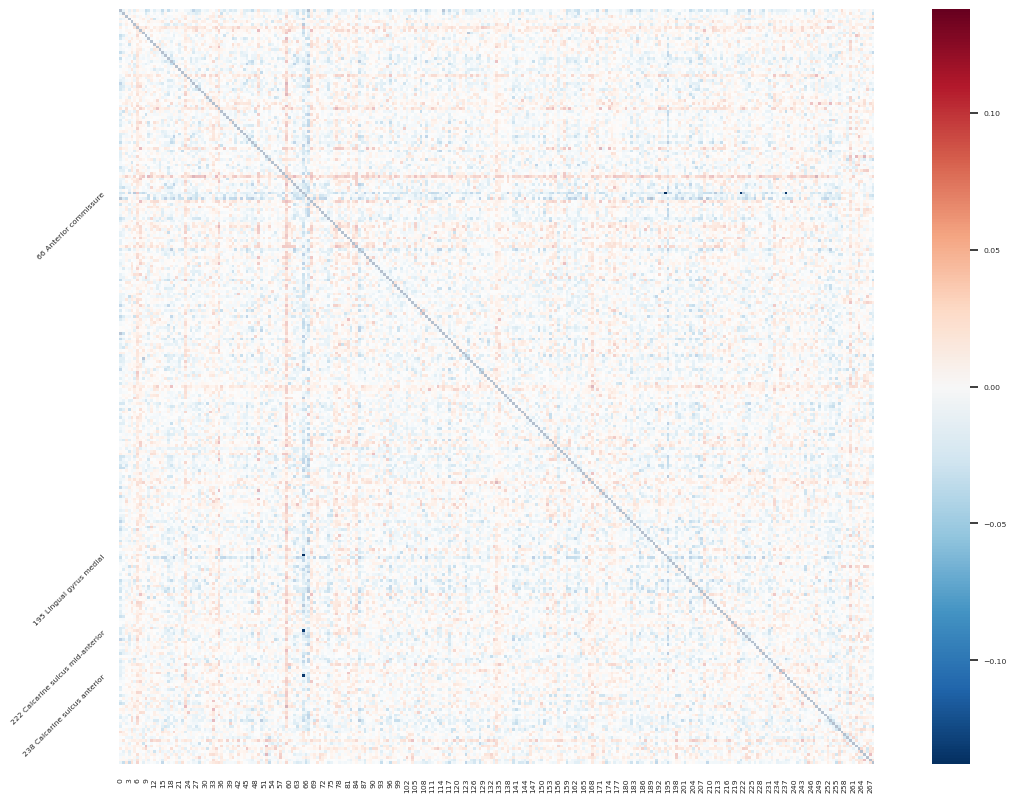

<Figure size 1440x1440 with 0 Axes>

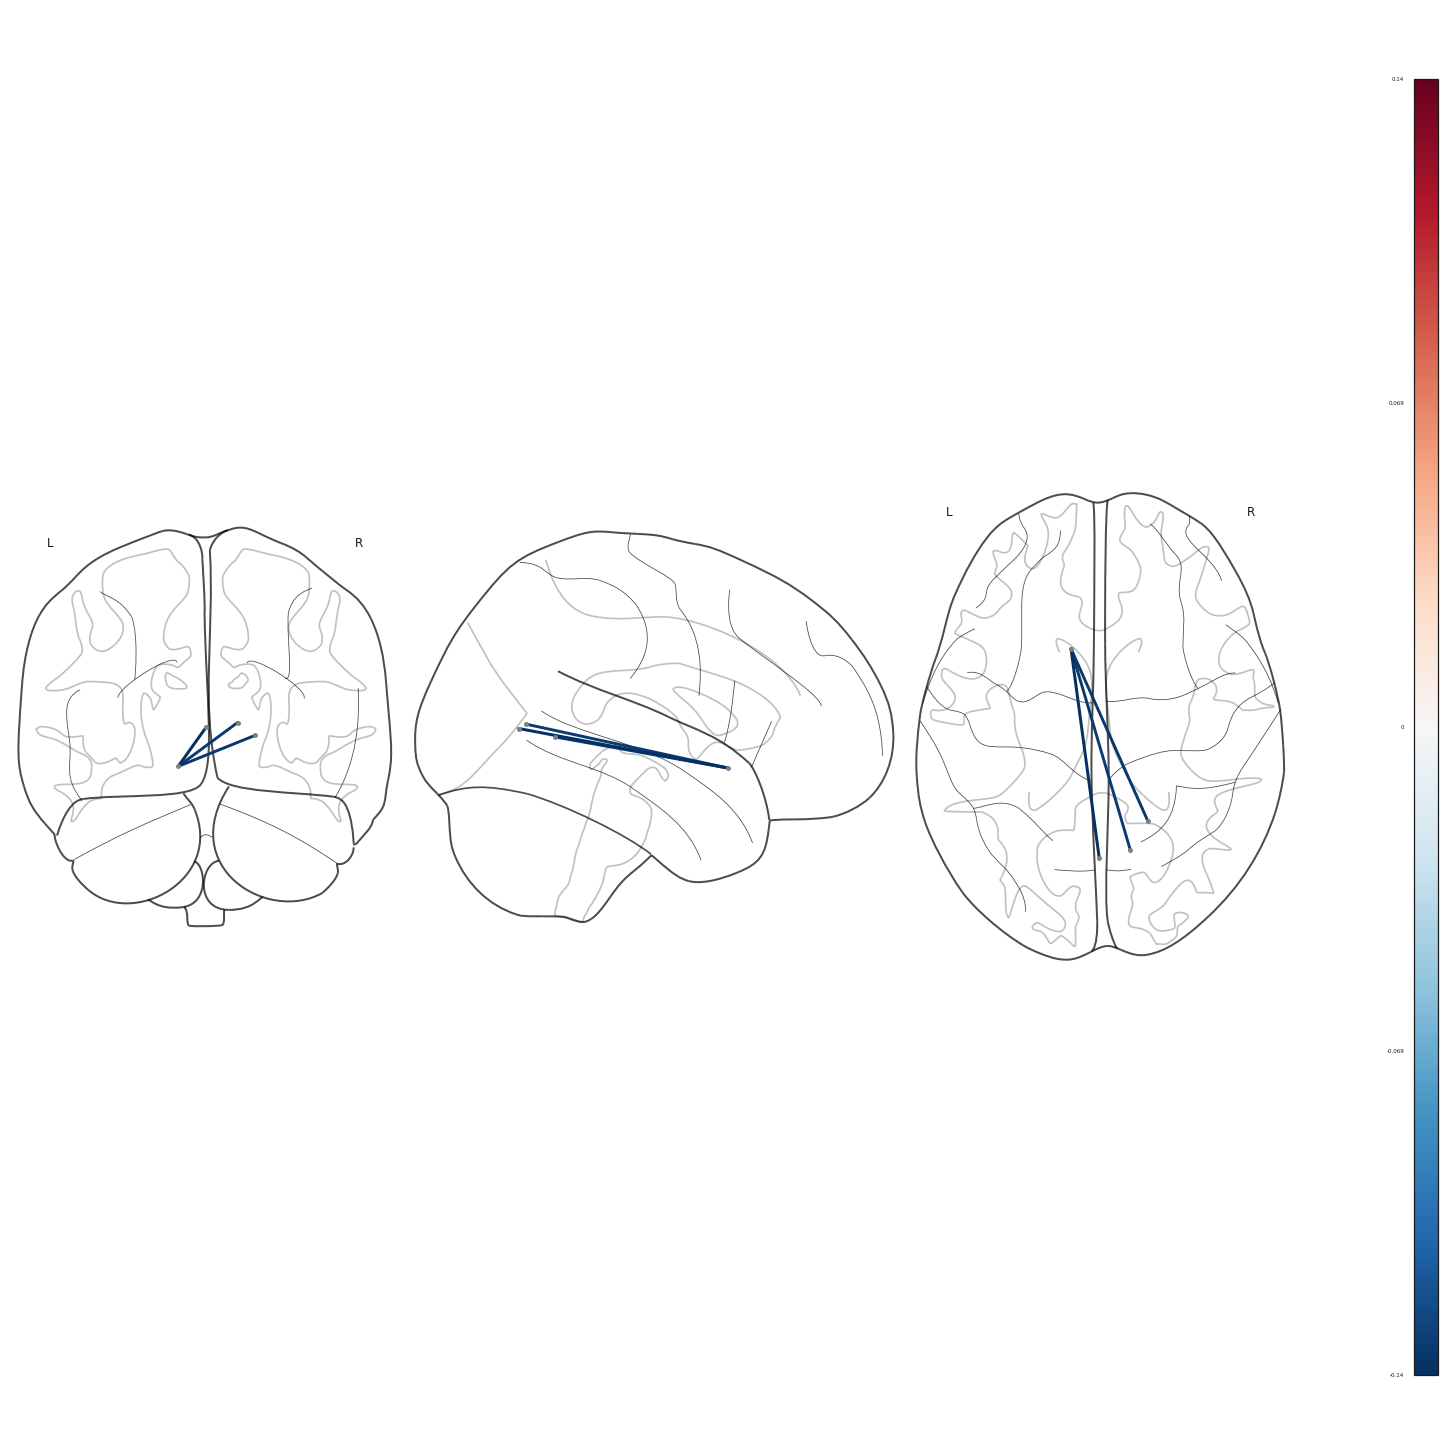

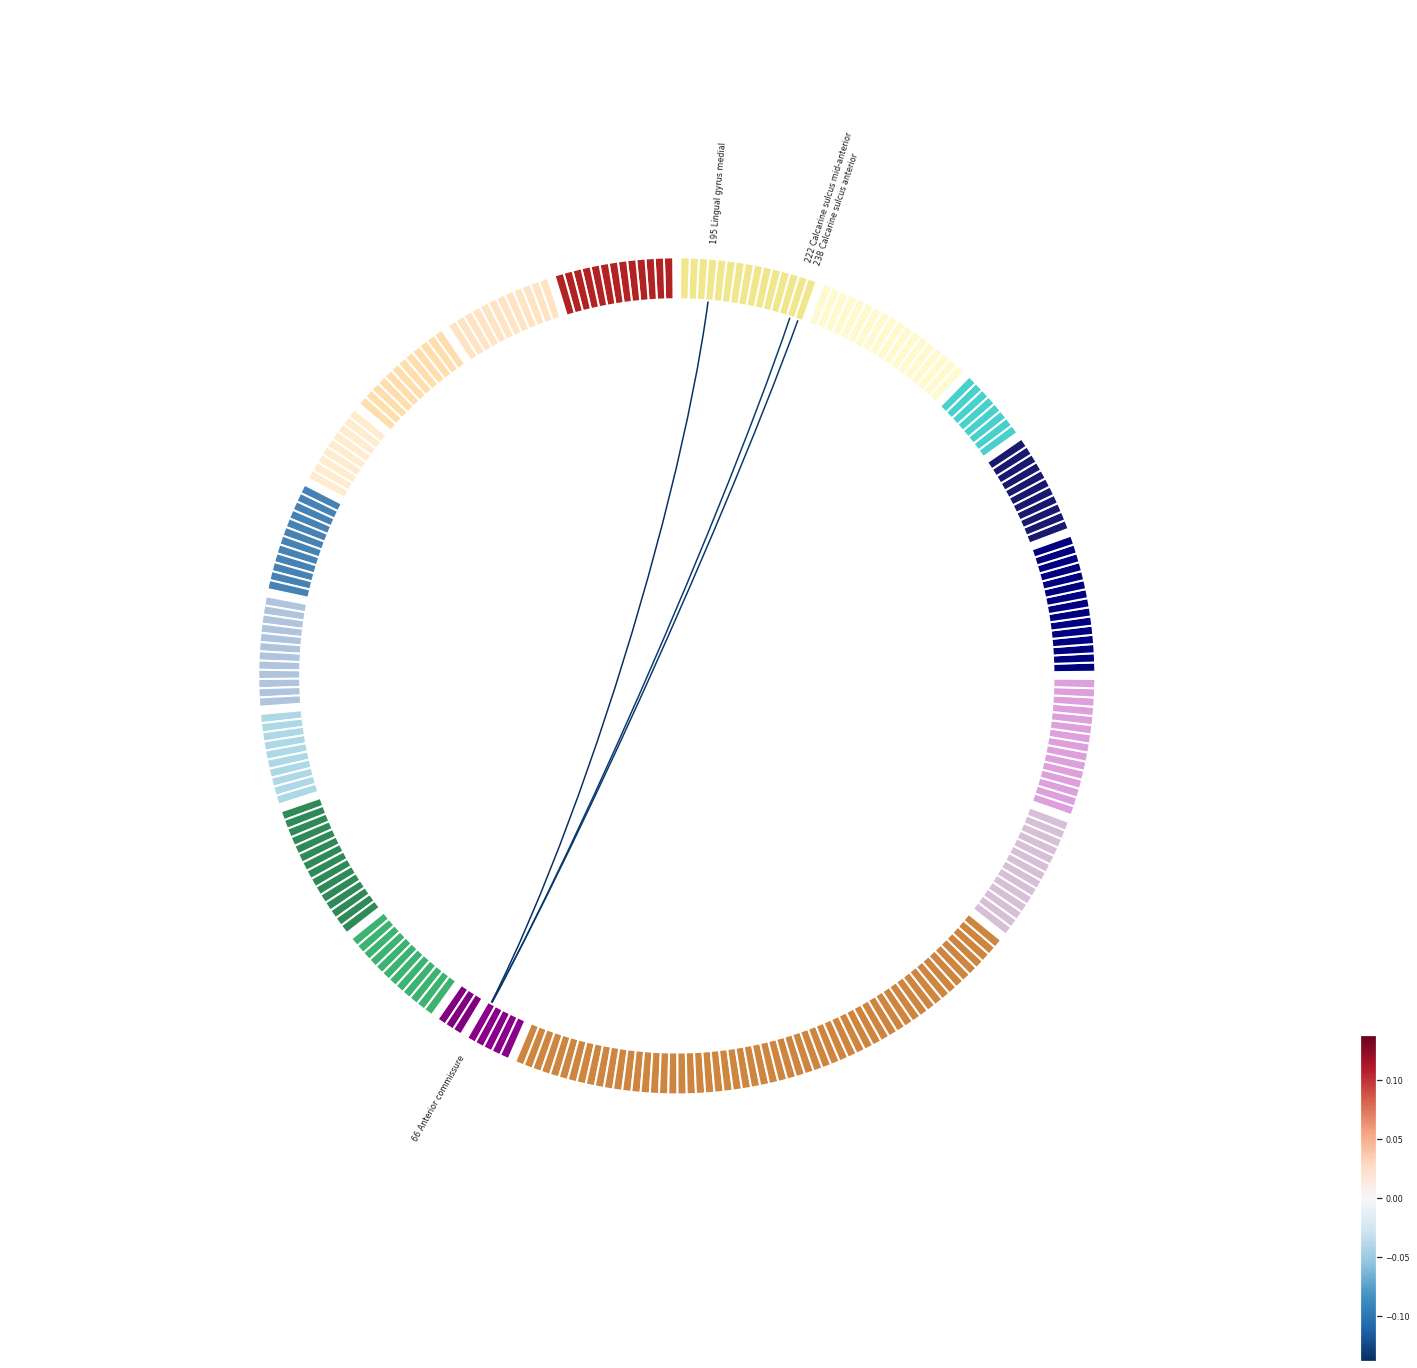

 Basal Ganglia has color: firebrick ContA has color: bisque ContB has color: navajowhite ContC has color: blanchedalmond DefaultA has color: steelblue DefaultB has color: lightsteelblue DefaultC has color: lightblue DorsAttnA has color: seagreen DorsAttnB has color: mediumseagreen LimbicA has color: purple LimbicB has color: darkmagenta No network found has color: peru SalVentAttnA has color: thistle SalVentAttnB has color: plum SomMotA has color: navy SomMotB has color: midnightblue TempPar has color: mediumturquoise VisCent has color: lemonchiffon VisPeri has color: khaki


In [89]:
threshod_and_plot(p_values_FU2_FU2_pain,
                  beta_FU2_FU2_pain,
                  'FU2',
                  df,
                  'FU2_csi_pain_sum',
                  ['sex', '_basic-model'])

***Age 23***

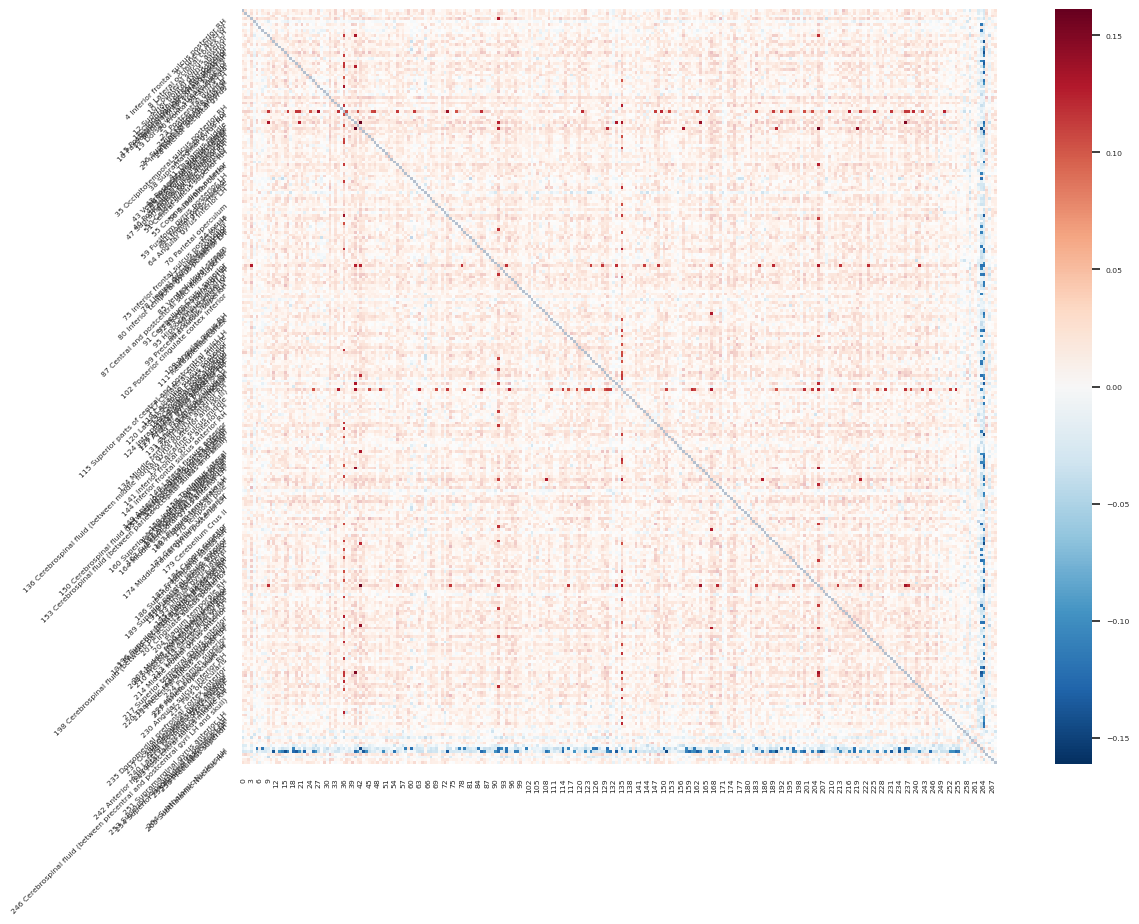

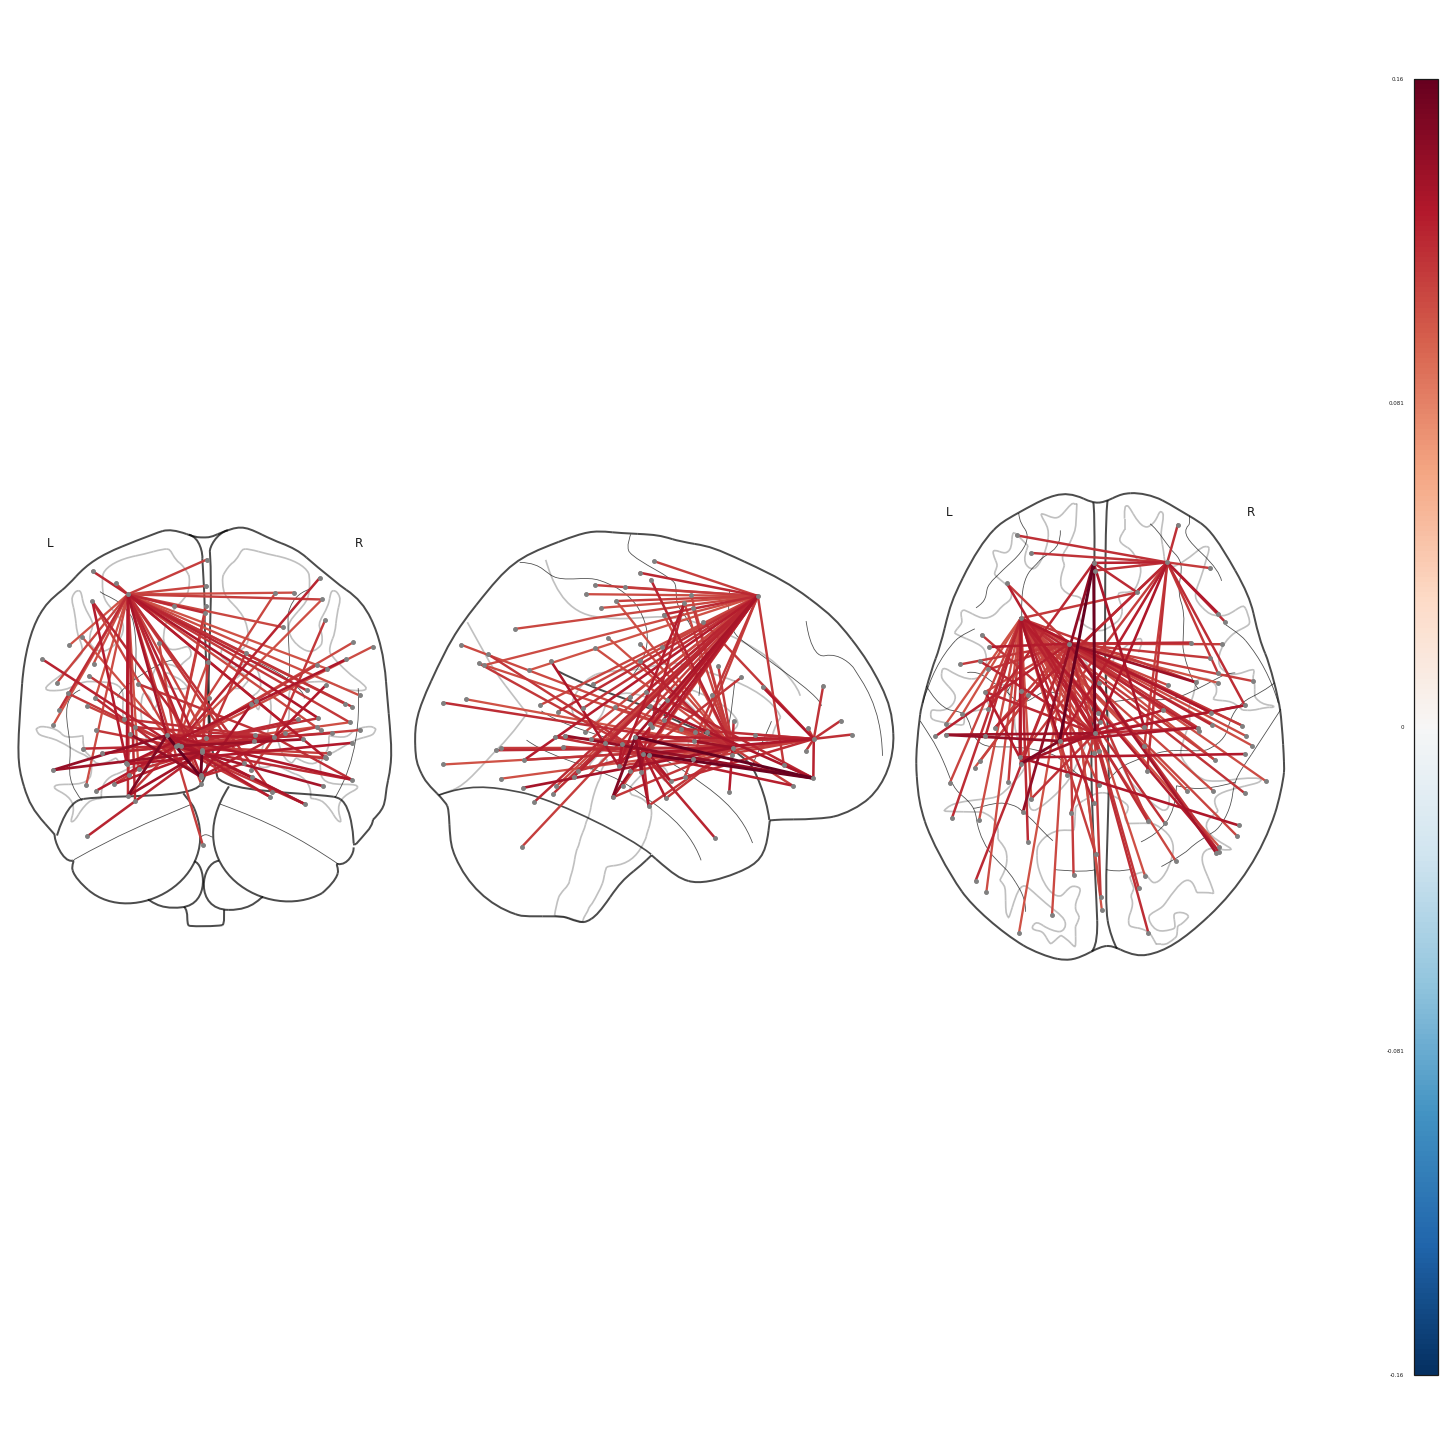

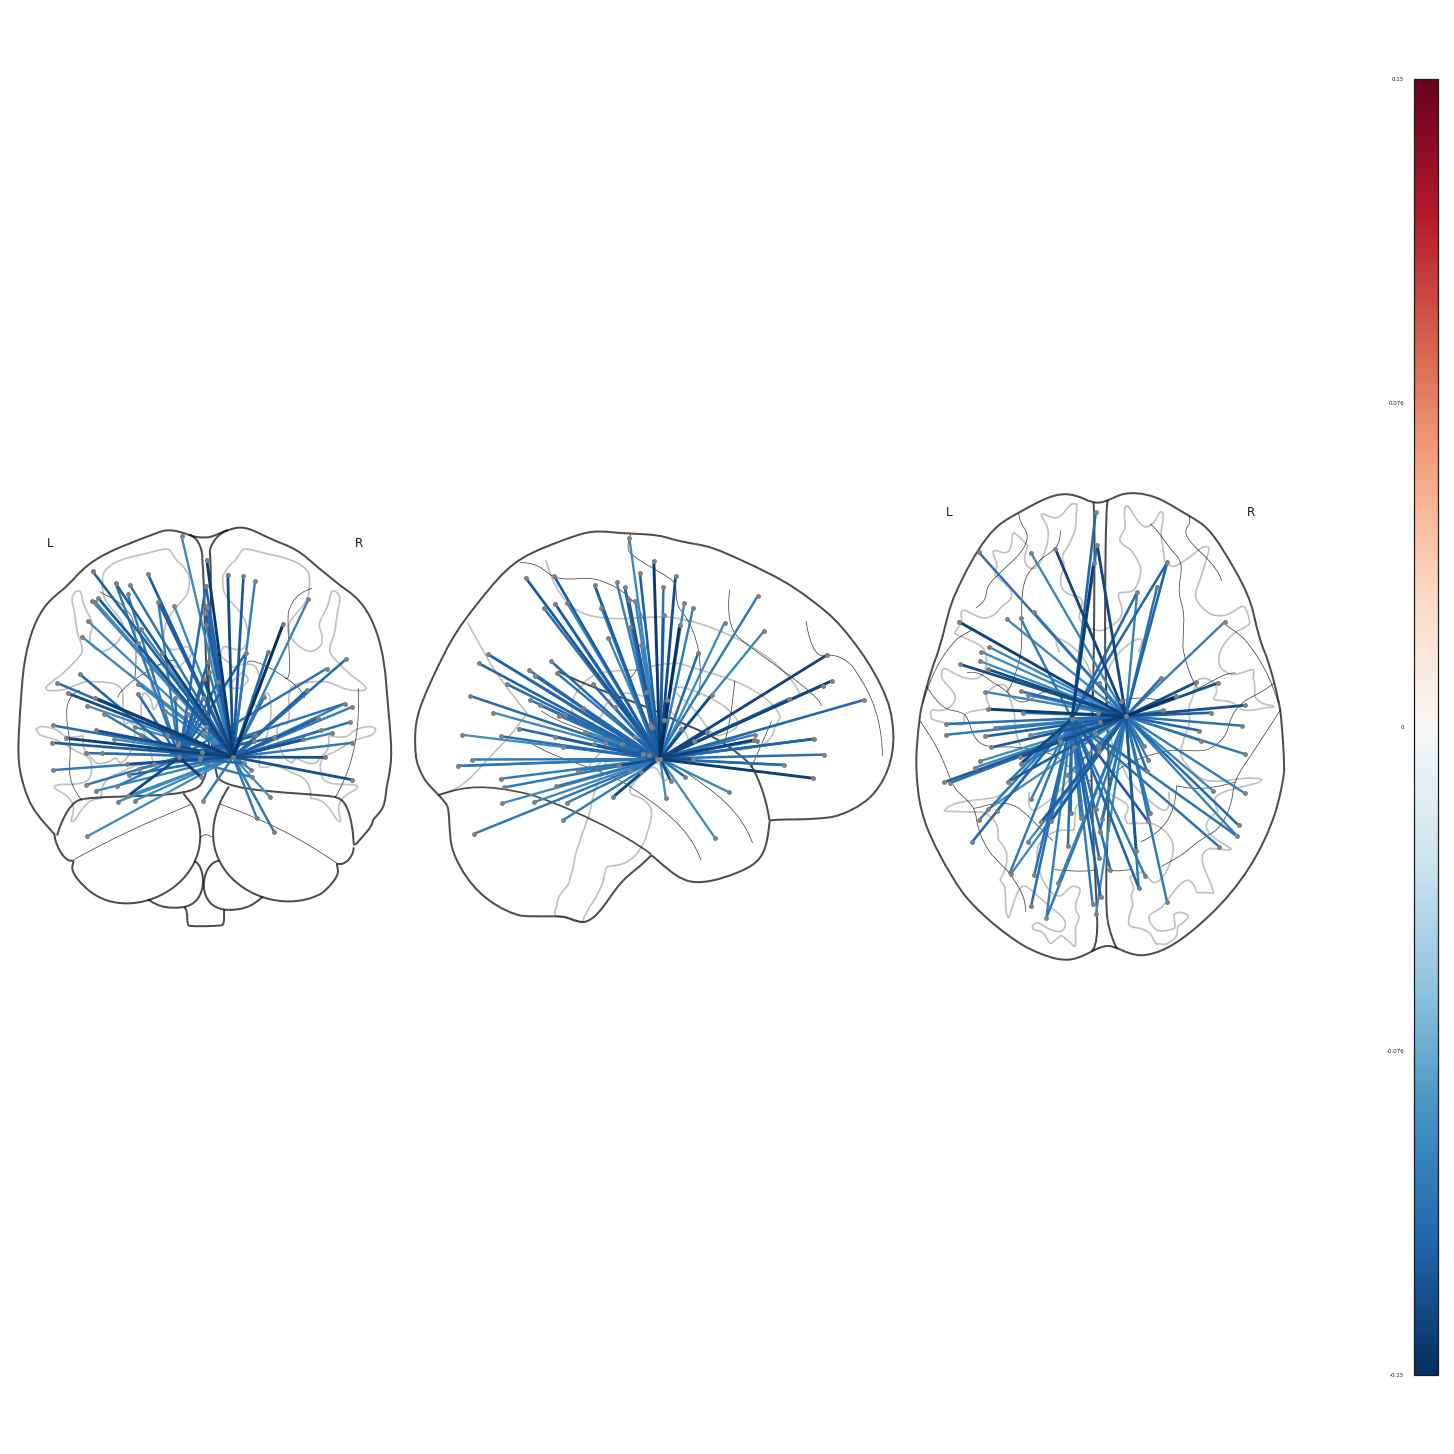

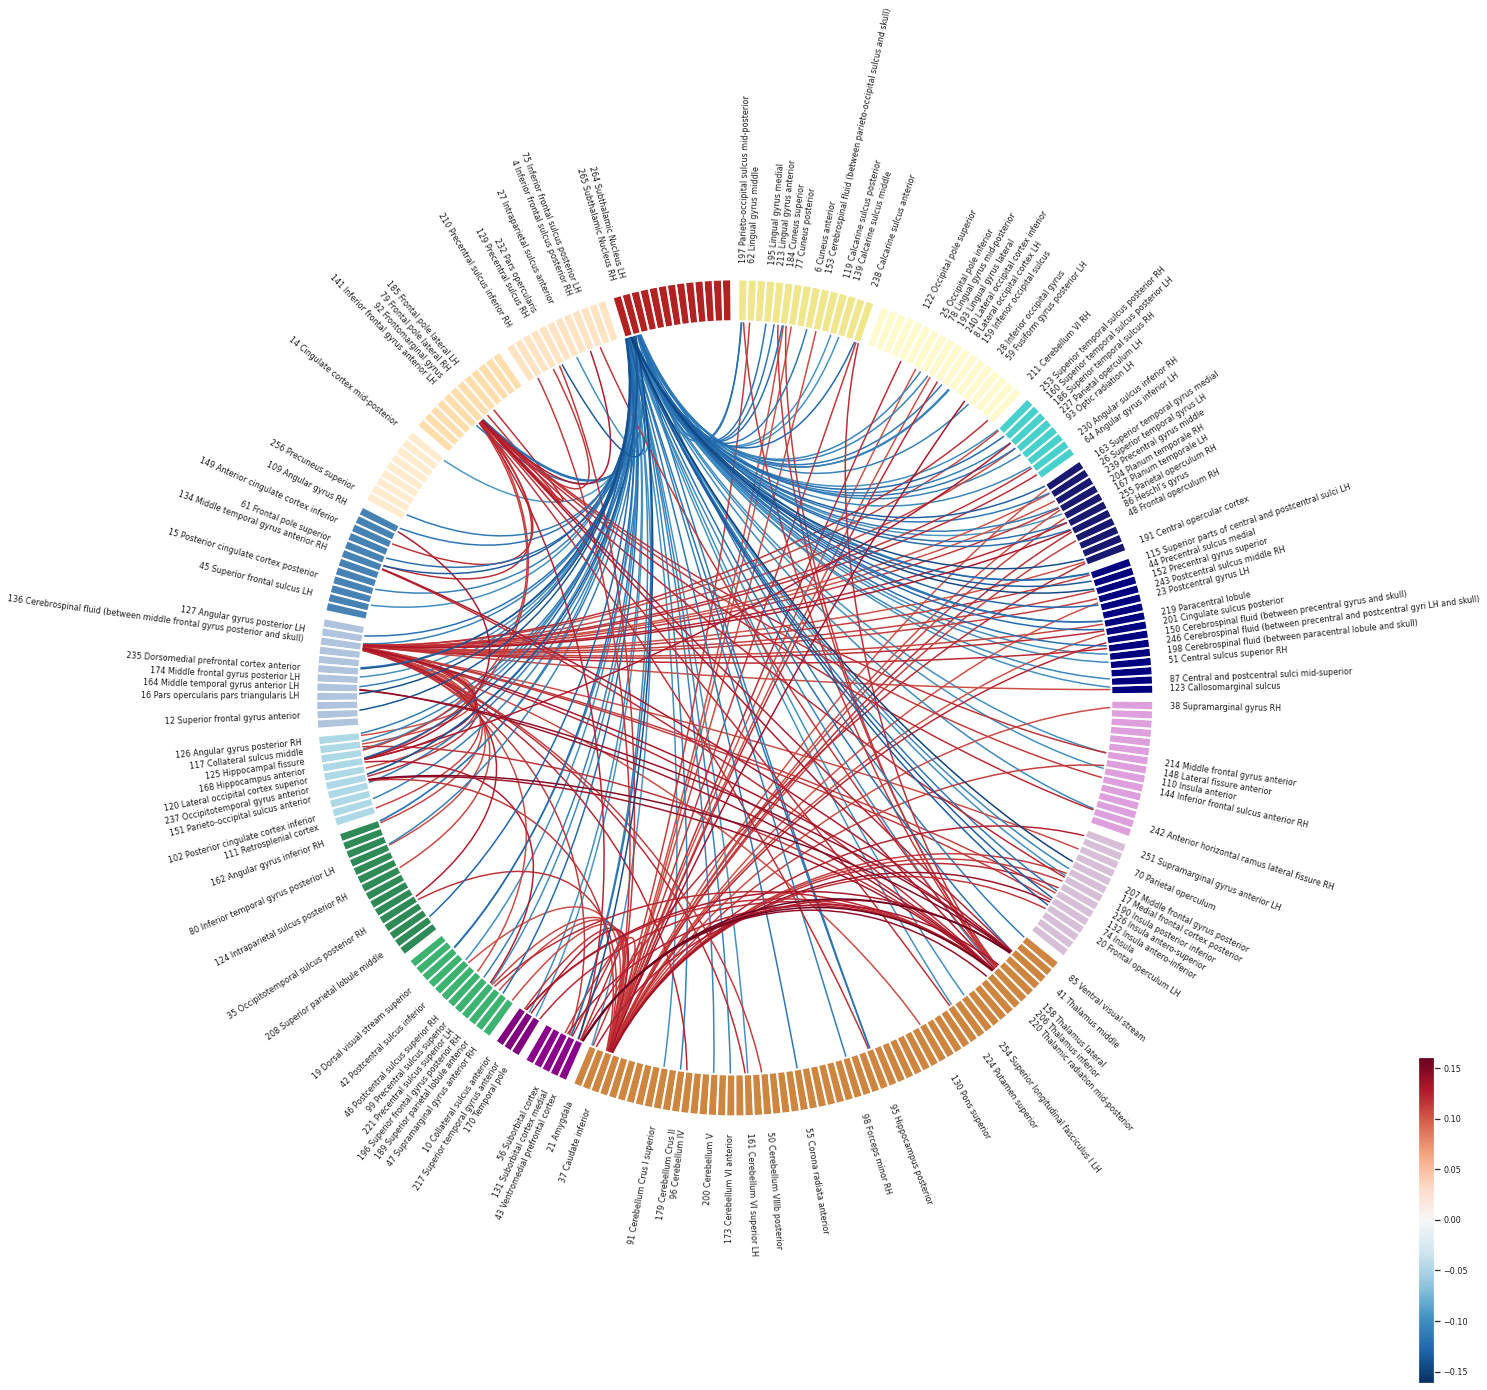

 Basal Ganglia has color: firebrick ContA has color: bisque ContB has color: navajowhite ContC has color: blanchedalmond DefaultA has color: steelblue DefaultB has color: lightsteelblue DefaultC has color: lightblue DorsAttnA has color: seagreen DorsAttnB has color: mediumseagreen LimbicA has color: purple LimbicB has color: darkmagenta No network found has color: peru SalVentAttnA has color: thistle SalVentAttnB has color: plum SomMotA has color: navy SomMotB has color: midnightblue TempPar has color: mediumturquoise VisCent has color: lemonchiffon VisPeri has color: khaki


In [90]:
threshod_and_plot(p_values_FU3_FU3_pain,
                  beta_FU3_FU3_pain,
                  'FU3 ',
                  df,
                  'FU3_csi_pain_sum',
                  ['sex', '_basic-model'])

**Age 19 & 23 comparision**

Plot both ages in one heatmap.

In [92]:
# Should maybe muck this out but anyway works so.... maybe I just leave this as this

# transform to np
p_values_FU2 = np.array(p_values_FU2_FU2_pain)
beta_FU2 = np.array(beta_FU2_FU2_pain)

p_values_FU3 = np.array(p_values_FU3_FU3_pain)
beta_FU3 = np.array(beta_FU3_FU3_pain)

# transform to np mat
pvalues_mat_FU2 = vec_to_sym_matrix(p_values_FU2)
beta_mat_FU2 = vec_to_sym_matrix(beta_FU2)

pvalues_mat_FU3 = vec_to_sym_matrix(p_values_FU3)
beta_mat_FU3 = vec_to_sym_matrix(beta_FU3)


length_corr_Vector = len(beta_FU2)-1  # for later indexing??

# ------------- Correct for multiple testing ------------------ #


# FU2
pvalues_df_FU2 = pd.DataFrame(pvalues_mat_FU2)  # make df out of mat
reject_df_FU2 = pd.DataFrame(pvalues_mat_FU2)  # prepare df in correct to fill with boolean index for rejection of hypothesis 

for i in pvalues_df_FU2.index:  # mask diagonal in p-value matrix as the values in the conn-matrices were constant and therefor not usable
    pvalues_df_FU2.iloc[i, i] = 1

# test for multiple correction roi-wise
for idx in pvalues_df_FU2.index:
    # get p-values of each roi and transform to list
    p_list_FU2 = pvalues_df_FU2.loc[idx, pvalues_df_FU2.columns != idx].to_list()  # Leave out cells in diagonal as they do not contain information
    # multiple test correction
    reject_FU2, pvals_corrected_FU2, alphaSid, alphaBonf = multipletests(p_list_FU2, alpha = 0.05, method= 'fdr_bh')
    pvalues_df_FU2.loc[idx, pvalues_df_FU2.columns != idx] = pvals_corrected_FU2
    reject_df_FU2.loc[idx, pvalues_df_FU2.columns != idx] = reject_FU2
    pvalues_df_FU2.loc[idx, idx] = 1  # fill diagnonal with 1 in p-values
    reject_df_FU2.loc[idx, idx] = False  # and in reject matrix with False
# back to np.matrix
pvalues_mat_FU2 = pvalues_df_FU2.to_numpy()
reject_mat_FU2 = reject_df_FU2.to_numpy()
# back to vec ????? i think this is not necessary as masking should be done with reject
pvalues_corrected_FU2 = sym_matrix_to_vec(pvalues_mat_FU2)

# make nonsymmetric matrix symmetric again
# hypothesis get rejected as sonn as for one of the two roi for which was roi-wise corrected the hypothesis was rejected.
# Might cause some alpha inflation, but other method would be far overly conservative. theoreti
reject1_FU2 = pd.DataFrame(reject_mat_FU2).copy().astype(int).to_numpy()
reject2_FU2 = pd.DataFrame(reject_mat_FU2).transpose().copy().astype(int).to_numpy()
reject_mat_FU2 = (reject1_FU2 + reject2_FU2) > 0

# make corresponding vector
reject_FU2 = sym_matrix_to_vec(reject_mat_FU2)

# idx for rois with significant results

relevant_roi_FU2 = (pd.DataFrame(reject_mat_FU2).astype(int).sum(axis=0) != 0).to_numpy()  #at least one
very_relevant_roi_FU2 = (pd.DataFrame(reject_mat_FU2).astype(int).sum(axis=0) > 3).to_numpy()  # at least three

# FU3

pvalues_df_FU3 = pd.DataFrame(pvalues_mat_FU3)  # make df out of mat
reject_df_FU3 = pd.DataFrame(pvalues_mat_FU3)  # prepare df in correct to fill with boolean index for rejection of hypothesis 

for i in pvalues_df_FU3.index:  #mask diagonal in p-value matrix as the values in the conn-matrices were constant and therefor not usable
    pvalues_df_FU3.iloc[i, i]=1

# test for multiple correction roi-wise
for idx in pvalues_df_FU3.index:
    # get p-values of each roi and transform to list
    p_list_FU3 = pvalues_df_FU3.loc[idx, pvalues_df_FU3.columns != idx].to_list()   #Leave out cells in diagonal as they do not contain information
    # multiple test correction
    reject_FU3, pvals_corrected_FU3, alphaSid, alphaBonf = multipletests(p_list_FU3, alpha = 0.05, method='fdr_bh')
    pvalues_df_FU3.loc[idx, pvalues_df_FU3.columns != idx] = pvals_corrected_FU3
    reject_df_FU3.loc[idx, pvalues_df_FU3.columns != idx] = reject_FU3
    pvalues_df_FU3.loc[idx, idx] = 1  # fill diagnonal with 1 in p-values
    reject_df_FU3.loc[idx, idx] = False  # and in reject matrix with False
# back to np.matrix
pvalues_mat_FU3 = pvalues_df_FU3.to_numpy()
reject_mat_FU3 = reject_df_FU3.to_numpy()
# back to vec ????? i think this is not necessary as masking should be done with reject
pvalues_corrected_FU3 = sym_matrix_to_vec(pvalues_mat_FU3)

# make nonsymmetric matrix symmetric again
# hypothesis get rejected as sonn as for one of the two roi for which was roi-wise corrected the hypothesis was rejected.
# Might cause some alpha inflation, but other method would be far overly conservative. theoreti
reject1_FU3 = pd.DataFrame(reject_mat_FU3).copy().astype(int).to_numpy()
reject2_FU3 = pd.DataFrame(reject_mat_FU3).transpose().copy().astype(int).to_numpy()
reject_mat_FU3 = (reject1_FU3+reject2_FU3) > 0

# make corresponding vector
reject_FU3 = sym_matrix_to_vec(reject_mat_FU3)


# idx for rois with significant results

relevant_roi_FU3 = (pd.DataFrame(reject_mat_FU3).astype(int).sum(axis=0) != 0).to_numpy()  #at least one
very_relevant_roi_FU3 = (pd.DataFrame(reject_mat_FU3).astype(int).sum(axis=0) > 3).to_numpy()  # at least three -> better for visualization otherwise its not really readable


#################################################################################################################################
################################################---plot matrix---################################################################
#################################################################################################################################

beta_mat_FU2 = pd.DataFrame(beta_mat_FU2)
beta_mat_FU3 = pd.DataFrame(beta_mat_FU3)
reject_mat_FU2 = pd.DataFrame(reject_mat_FU2)
reject_mat_FU3 = pd.DataFrame(reject_mat_FU3)
for idx in beta_mat_FU2.index:
    beta_mat_FU2.loc[idx, idx:] = beta_mat_FU3.loc[idx, idx:]
    reject_mat_FU2.loc[idx, idx:] = reject_mat_FU3.loc[idx, idx:]

# make thresholded aquivalent to compute max value of significant results
beta_thresholded = beta_mat_FU2.copy()
beta_thresholded.to_numpy()[reject_mat_FU2.to_numpy() == False] = 0

# compute maximal values for colorbars in graphics
max_value = np.nanmax(beta_thresholded)
min_value = abs(np.nanmin(beta_thresholded))
if min_value > max_value:
    max_value = min_value




labels_thresholded_FU2 = []
labels_thresholded_FU3 = []
for idx, idx2, label in zip(very_relevant_roi_FU2, very_relevant_roi_FU3, DK_labels_short):
    if idx:
        labels_thresholded_FU2.append(label)
        labels_thresholded_FU3.append('')
    elif idx2:
        labels_thresholded_FU3.append(label)
        labels_thresholded_FU2.append('')
    else:
        labels_thresholded_FU2.append('')
        labels_thresholded_FU3.append('')


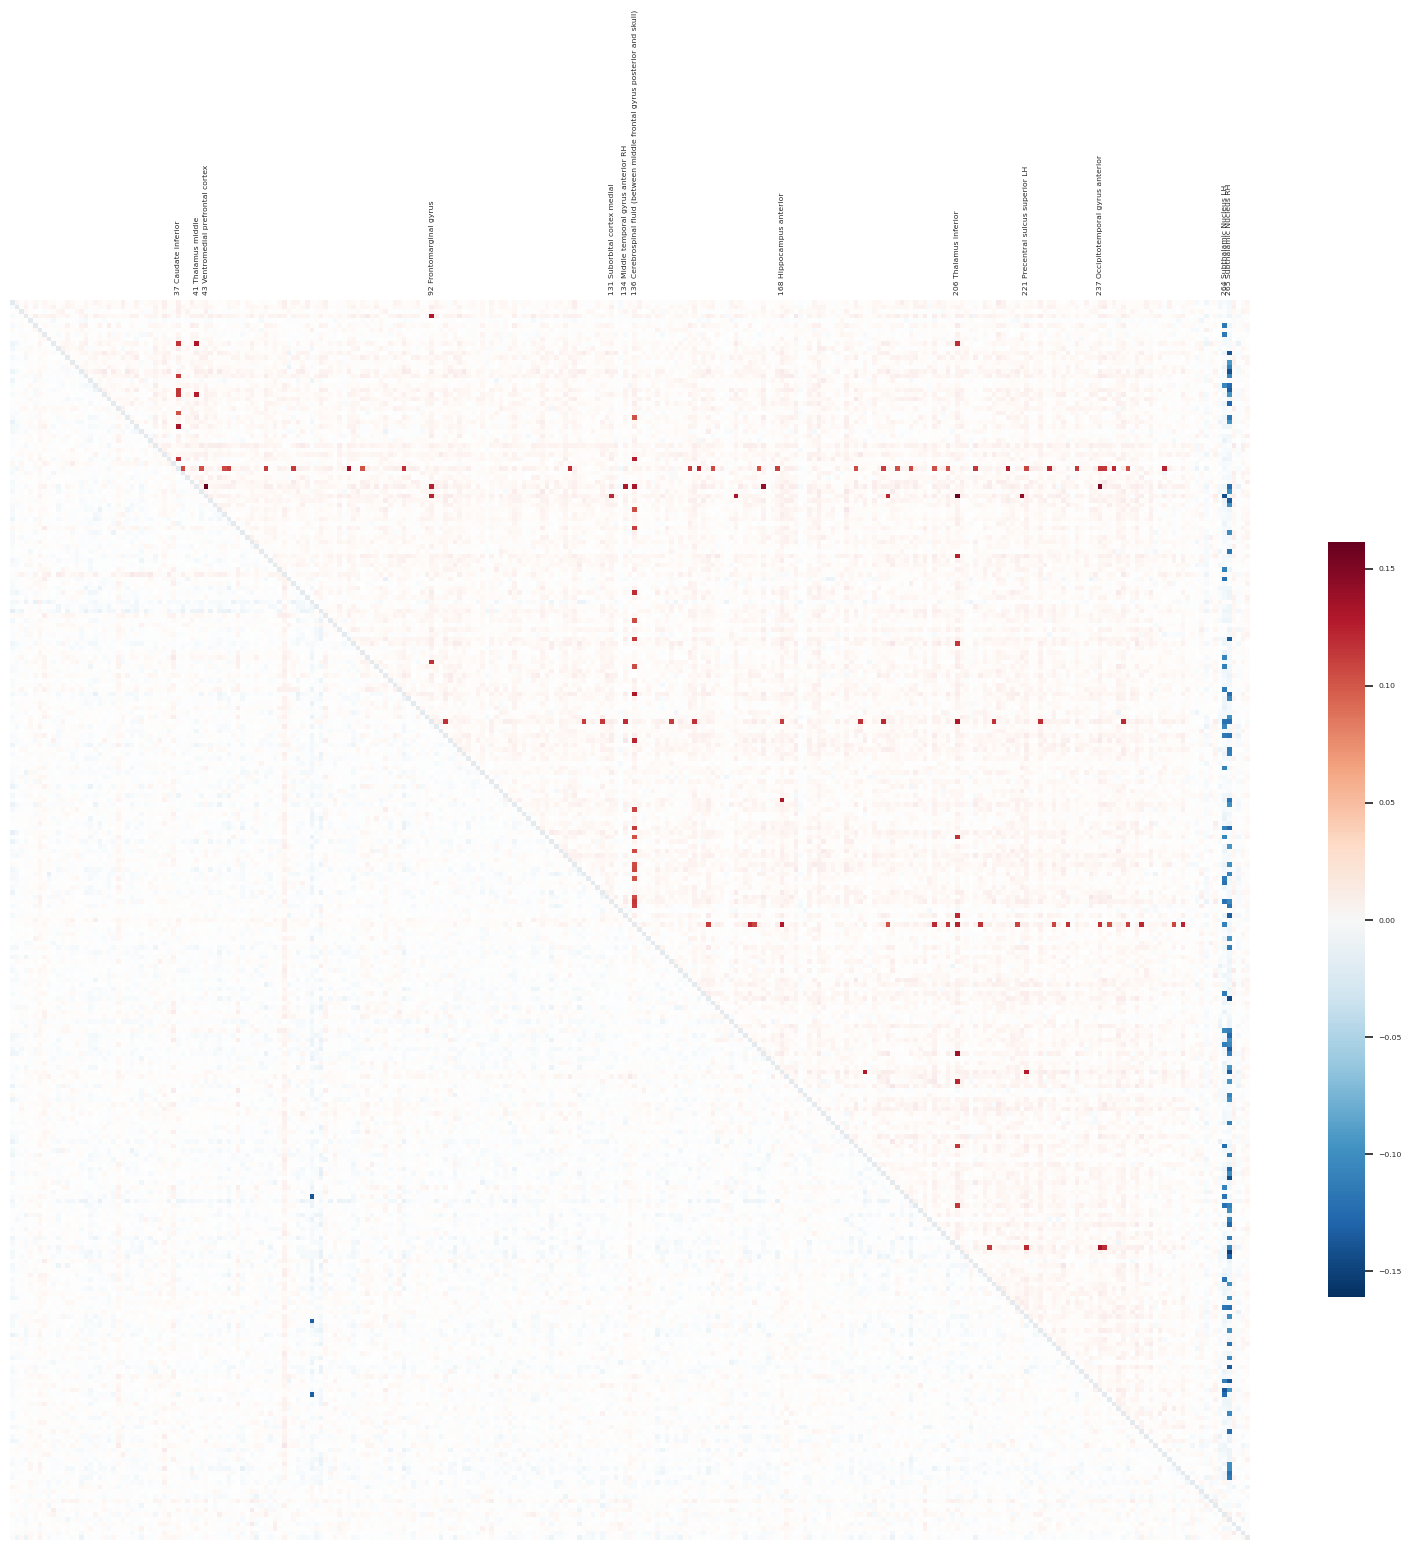

In [94]:
# make colormap with transparent white to overlay for not rejected effects
colors = [(0, 0, 0, 0)]
colors = colors + [(1, 1, 1, c) for c in np.linspace(0.8, 0.9, 100)]
cmapred = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap',
                                                              colors,
                                                              N=40)

sns.set(font_scale=0.5)
fig = plt.figure(figsize=(20, 20),
                 dpi=100)  # plot some high resolution figure
ax1 = sns.heatmap(beta_mat_FU2,
                  cmap=plt.cm.RdBu_r,
                  center=0, square=True,
                  vmin=-max_value,
                  vmax=max_value,
                  cbar_kws={"shrink": .5}) # add beta heatmap
ax1.xaxis.set_label_position('top')
ax1.xaxis.tick_top()
ax1.tick_params(length=0)
fig.axes.append(ax1)

ax2 = sns.heatmap(pd.DataFrame(reject_mat_FU2 == False).astype('int'),
                  cmap=colors,
                  vmax=0.05,
                  cbar=False,
                  yticklabels=labels_thresholded_FU2,
                  xticklabels=labels_thresholded_FU3,
                  square=True)  # overlay non significant effects with white transparent colour
ax2.xaxis.tick_top()
ax2.tick_params(length=0)
ax2.xaxis.set_label_position('top')
fig.axes.append(ax2)

#### Advanced Model

Model with effects on **Pain/Weakness** by *Brain Connectivity Changes* (23-19) controlled by *Baseline Brain Connectivity* (19) and *Sex*.

$$ Pain/Weakness(23) \sim rsFC(23-19) + rsFC(19) + sex $$

**Brain Reorganisation** (FU3-FU2)

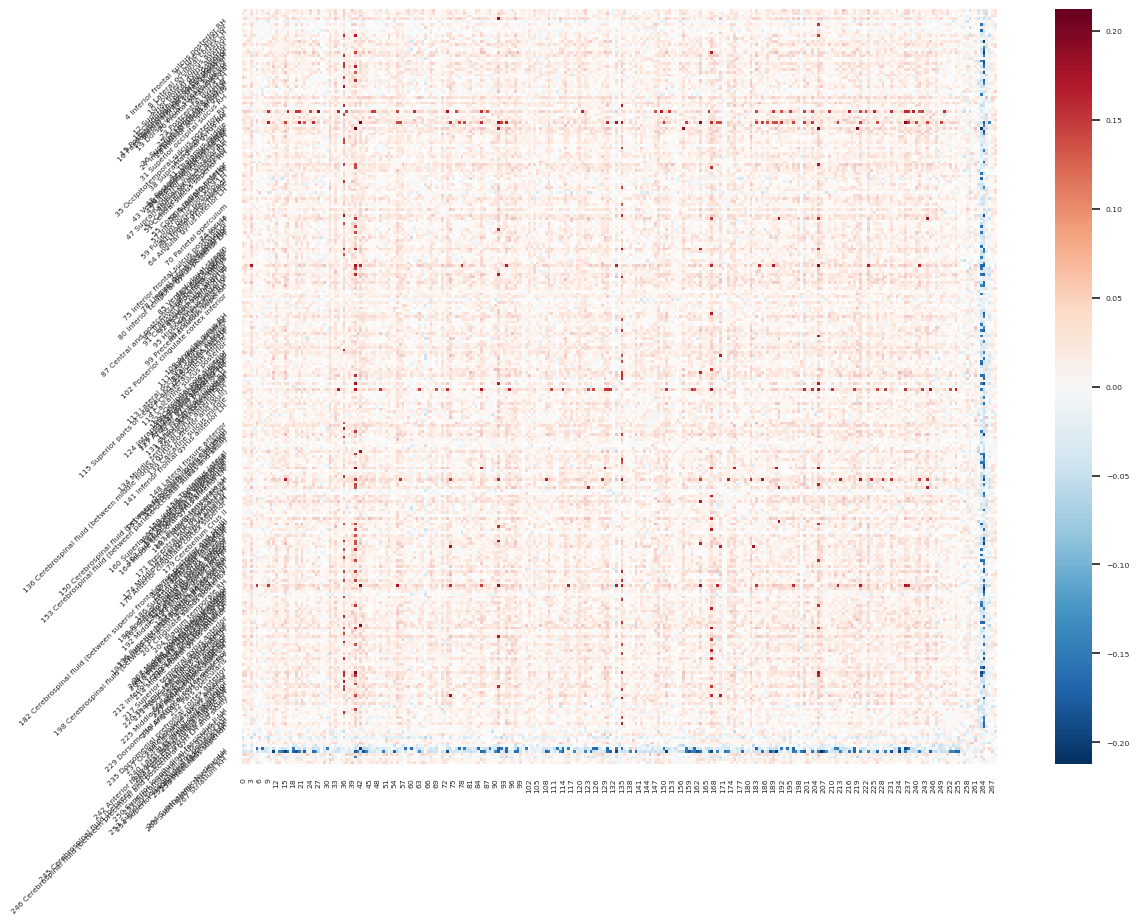

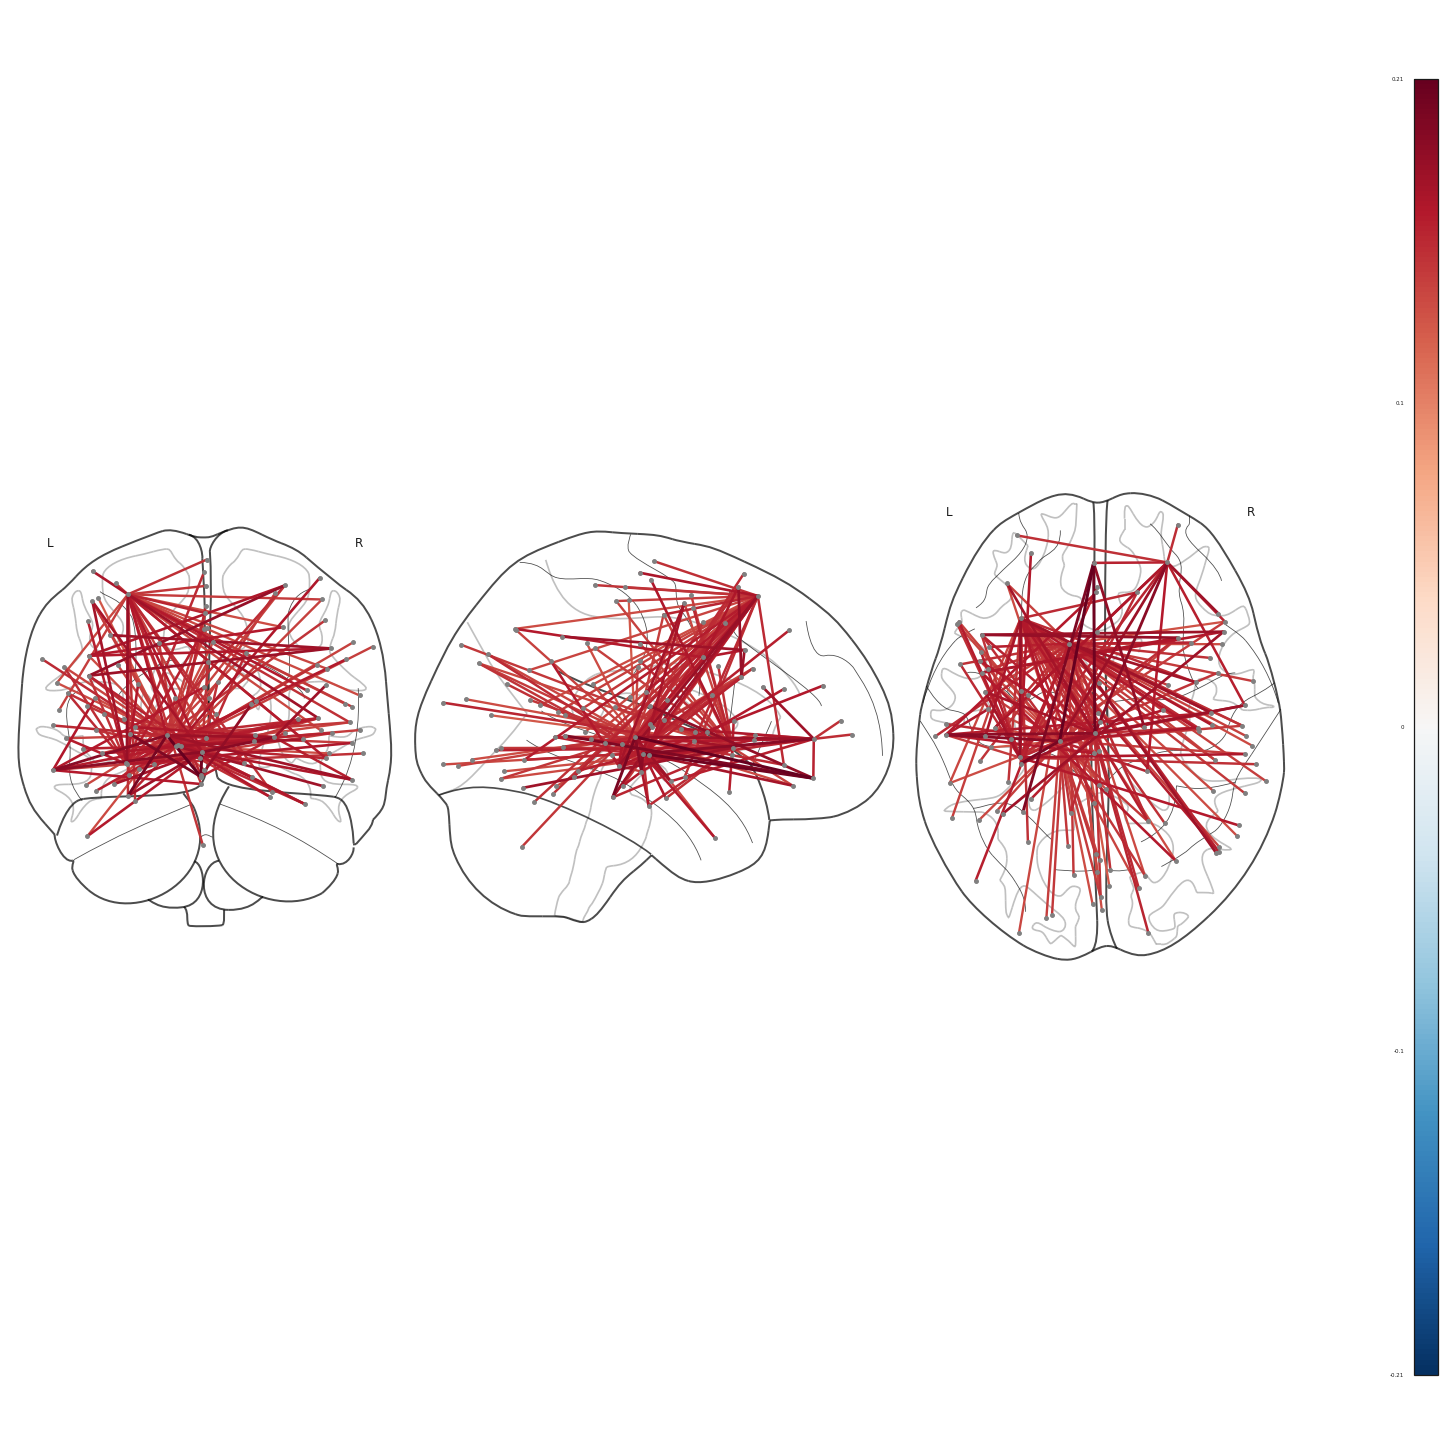

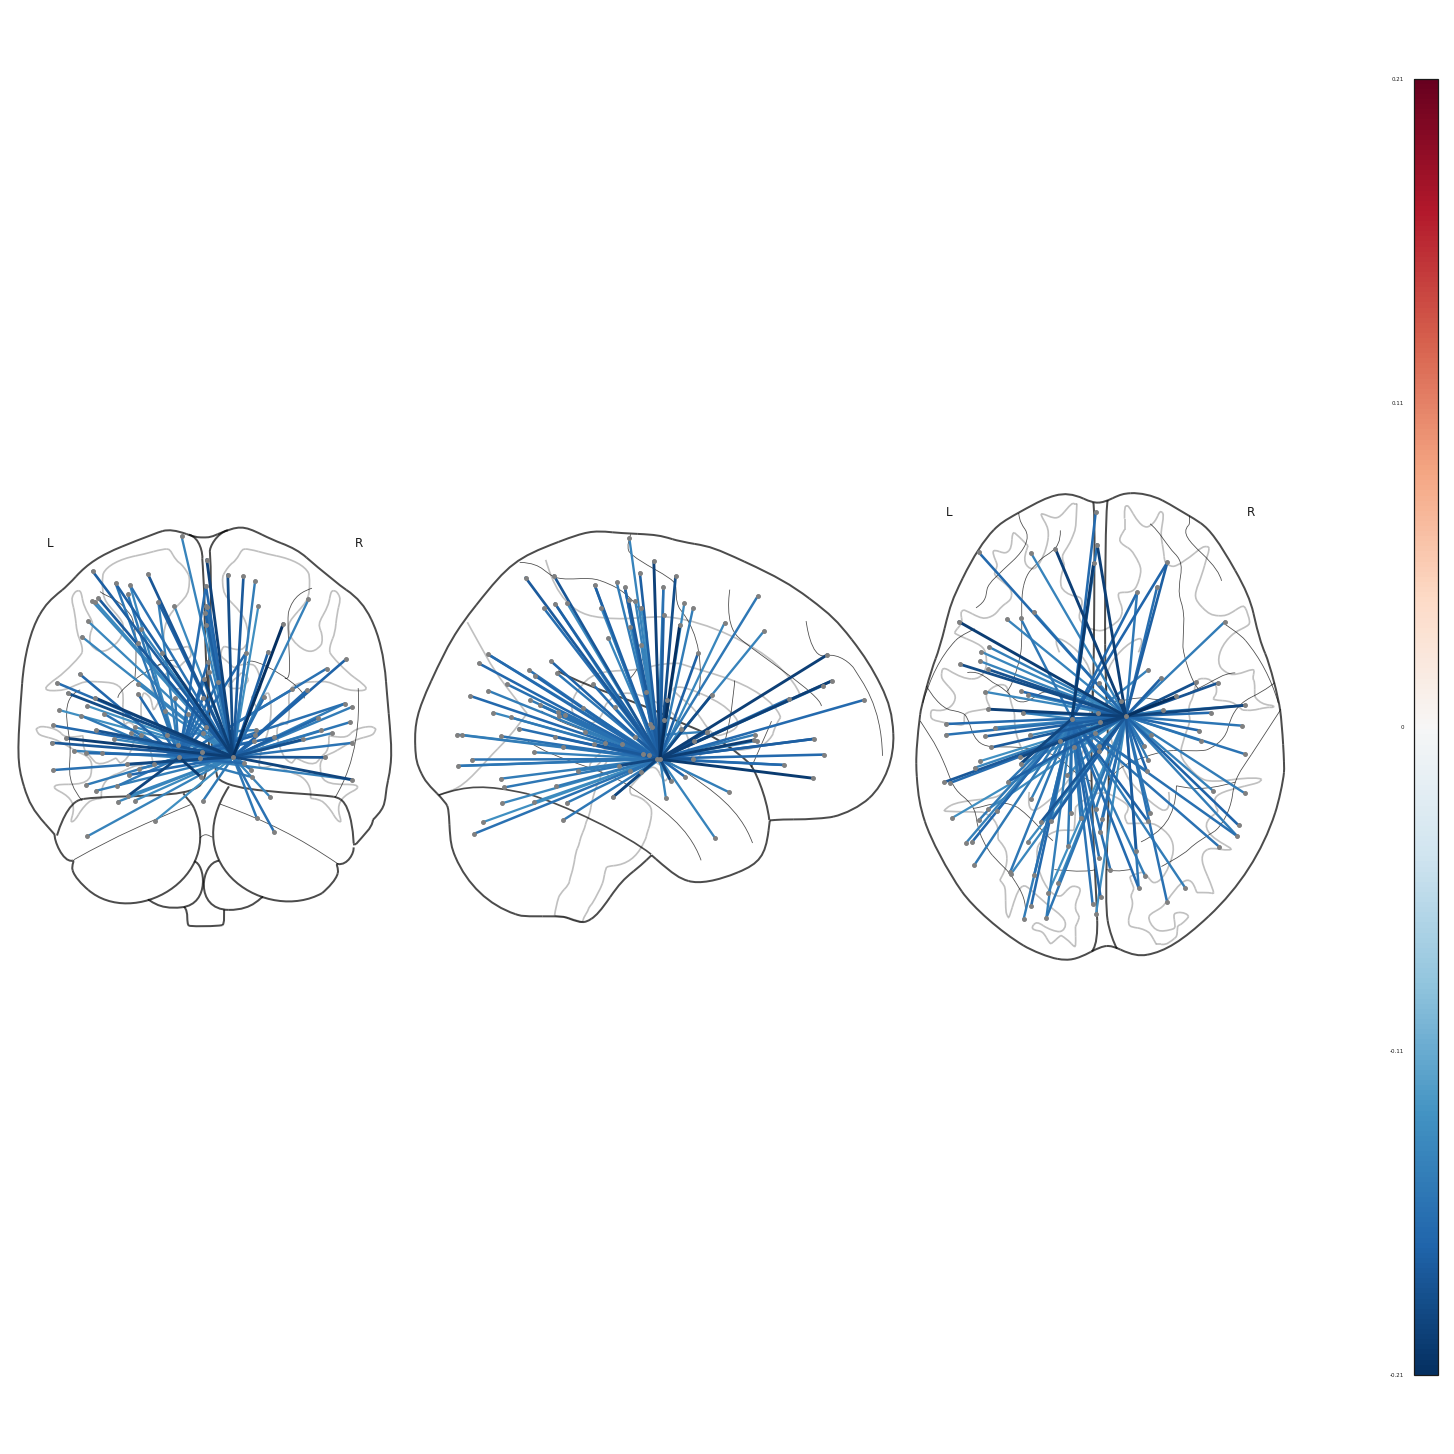

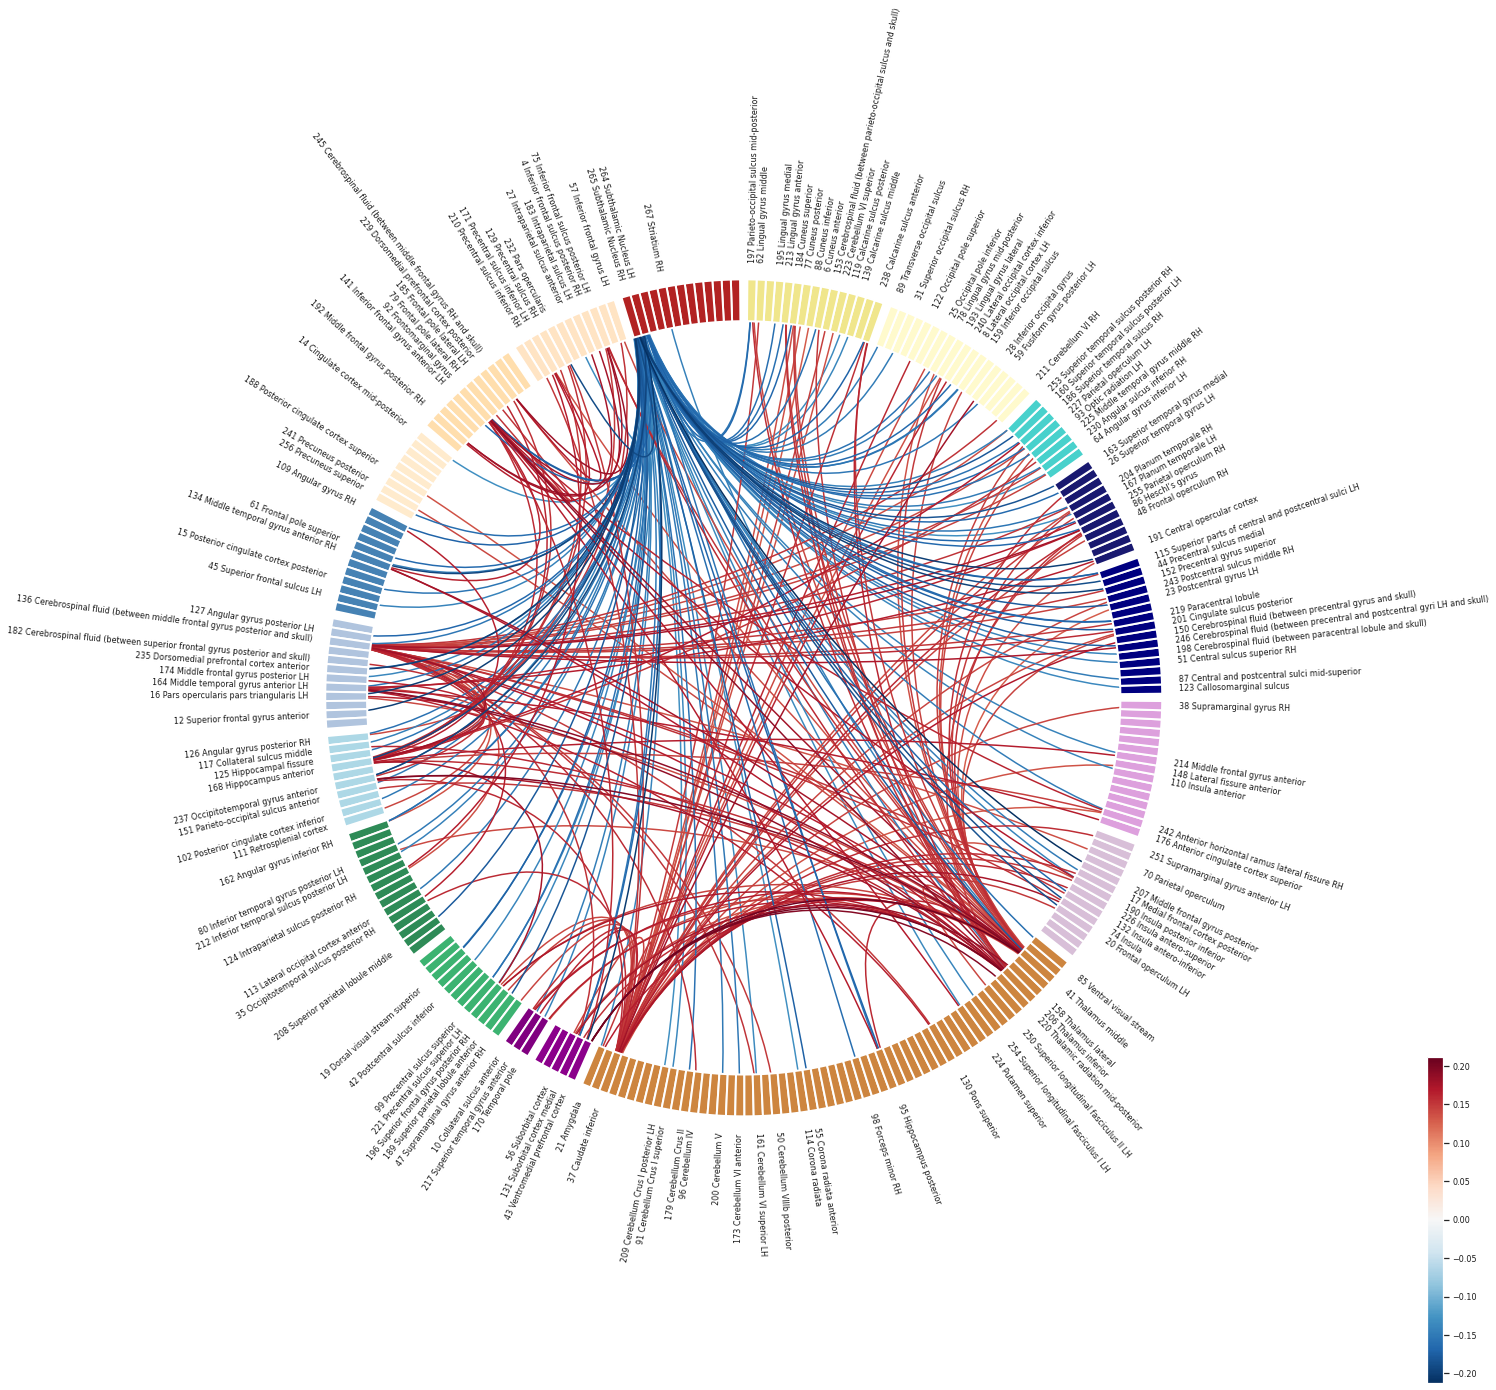

 Basal Ganglia has color: firebrick ContA has color: bisque ContB has color: navajowhite ContC has color: blanchedalmond DefaultA has color: steelblue DefaultB has color: lightsteelblue DefaultC has color: lightblue DorsAttnA has color: seagreen DorsAttnB has color: mediumseagreen LimbicA has color: purple LimbicB has color: darkmagenta No network found has color: peru SalVentAttnA has color: thistle SalVentAttnB has color: plum SomMotA has color: navy SomMotB has color: midnightblue TempPar has color: mediumturquoise VisCent has color: lemonchiffon VisPeri has color: khaki


In [95]:
threshod_and_plot(pvalues_diff_on_FU3_base_control,
                  beta_diff_on_FU3_base_control,
                  'diff ',
                  df,
                  'FU3_csi_pain_sum',
                  ['sex', '_advanced-model'])

## Post-hoc-Analysis

Effects of cortical Integration of the Subthalamic Nuclei on **Pain/Weakness**

In [97]:
# Compute mean cortical rs-FC of both STN to the DiFuMo

df_mean_conn = df.copy()

# prepare Dataframe
for timepoint in ['FU2', 'diff', 'FU3']:
    mean_connectivities = []
    len_corr_vector = len(sym_matrix_to_vec(df.loc[df.index[5], str('corrmat_' + pipeline_to_use + '_FU2_Keu_DiF_combined')].to_numpy()))-1  # length of vector representing correlation-matrix
    for sub in df.index:
        sub_conn_matrix = df.loc[sub, str('corrmat_' + pipeline_to_use + '_' + timepoint + '_Keu_DiF_combined')] 
        sub_conn_matrix.set_axis(DK_labels, axis=0, inplace=True)
        sub_conn_matrix.set_axis(DK_labels, axis=1, inplace=True)
        mean_conn_L = sub_conn_matrix.loc[:sub_conn_matrix.index[255],
                                          sub_conn_matrix.columns[263]].mean()  #compute Mean connectivity of  STN_L with cortical noedes (exclude itself and other ROi from Keuken (2015))
        mean_conn_R = sub_conn_matrix.loc[:sub_conn_matrix.index[255],
                                          sub_conn_matrix.columns[264]].mean()  # Same for right
        mean_conn = (mean_conn_L + mean_conn_R)/2  # mean of both
        mean_connectivities.append(mean_conn) # put in list

    mean_connectivities_scaled = (np.array(mean_connectivities)-np.array(mean_connectivities).mean()) / np.array(mean_connectivities).std()  # z-scale
    mean_connectivities = pd.DataFrame(mean_connectivities_scaled).set_index(df.index).set_axis([str('mean_cort_conn_STN_' + timepoint)], axis=1)  # put to df

    # combine with big data frame
    df_mean_conn = pd.concat([mean_connectivities,df_mean_conn], axis=1) 
    df_mean_conn = add_constant(df_mean_conn)

/gxfs_home/cau/suknp018/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [98]:
model = OLS(endog=df_mean_conn.loc[:, ['FU3_csi_pain_sum']],
            exog=df_mean_conn.loc[:, ['mean_cort_conn_STN_diff',
                                      'mean_cort_conn_STN_FU2']]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       FU3_csi_pain_sum   R-squared (uncentered):                   0.024
Model:                            OLS   Adj. R-squared (uncentered):              0.022
Method:                 Least Squares   F-statistic:                              8.611
Date:                Mon, 14 Feb 2022   Prob (F-statistic):                    0.000202
Time:                        16:02:34   Log-Likelihood:                         -970.54
No. Observations:                 690   AIC:                                      1945.
Df Residuals:                     688   BIC:                                      1954.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
mean_cort_conn_STN_diff    -0.2034      0.051     -4.003      0.000      -0.303      -0.104
mean_cort_conn_STN_FU2     -0.0954      0.051     -1.877      0.061      -0.195       0.004
==============================================================================
Omnibus:                      470.826   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5248.493
Skew:                           3.014   Prob(JB):                         0.00
Kurtosis:                      15.092   Cond. No.                         2.25
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

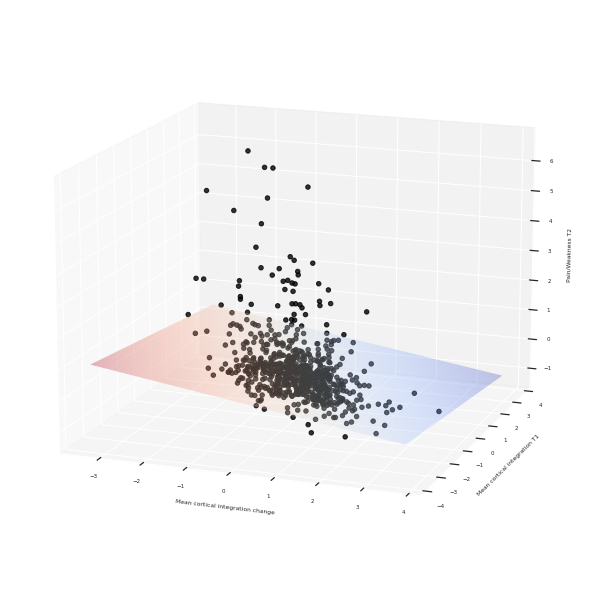

In [99]:
from matplotlib import pyplot, colors
from mpl_toolkits.mplot3d import Axes3D

cmap = colors.ListedColormap(['black'])


fig = pyplot.figure(figsize=(8, 8), facecolor='white')
ax = Axes3D(fig, auto_add_to_figure=False)
ax.set_zlabel('Pain/Weakness T2')
ax.set_ylabel('Mean cortical integration T1')
ax.set_xlabel('Mean cortical integration change')
ax.set_facecolor('None')

sequence_containing_x_vals = df_mean_conn.loc[:, ['mean_cort_conn_STN_diff']]
sequence_containing_y_vals = df_mean_conn.loc[:, ['mean_cort_conn_STN_FU2']]
sequence_containing_z_vals = df_mean_conn.loc[:, ['FU3_csi_pain_sum']]
# plot regression
x_surf, y_surf = np.meshgrid(np.linspace(sequence_containing_x_vals.min(),
                                         sequence_containing_x_vals.max(), 1000),
                             np.linspace(sequence_containing_y_vals.min(),
                                         sequence_containing_y_vals.max(), 1000 )
                                        )
onlyX = pd.DataFrame({'mean_cort_conn_STN_diff': x_surf.ravel(),
                      'mean_cort_conn_STN_FU2': y_surf.ravel()})

fittedY = model.predict(exog=onlyX)

ax.plot_surface(x_surf,
                y_surf,
                np.array(fittedY).reshape(x_surf.shape),
                alpha=0.3,
                cmap=matplotlib.cm.coolwarm,
                edgecolor='none')

# plot Scatterplot
ax.scatter(sequence_containing_x_vals,
           sequence_containing_y_vals,
           sequence_containing_z_vals,
           c=sequence_containing_z_vals,
           cmap=cmap,
           alpha=0.8)
fig.add_axes(ax)
ax.view_init(15, 290)
plt.show()

***
# Supplemantary Material

## Slurm Job

***

## fmriPrep

Results included in this manuscript come from preprocessing performed using fMRIPrep 20.2.3 (Esteban, Markiewicz, et al. (2018); Esteban, Blair, et al. (2018); RRID:SCR_016216), which is based on Nipype 1.6.1 (Gorgolewski et al. (2011); Gorgolewski et al. (2018); RRID:SCR_002502).

Anatomical data preprocessing

    A total of 1 T1-weighted (T1w) images were found within the input BIDS dataset.The T1-weighted (T1w) image was corrected for intensity non-uniformity (INU) with N4BiasFieldCorrection (Tustison et al. 2010), distributed with ANTs 2.3.3 (Avants et al. 2008, RRID:SCR_004757), and used as T1w-reference throughout the workflow. The T1w-reference was then skull-stripped with a Nipype implementation of the antsBrainExtraction.sh workflow (from ANTs), using OASIS30ANTs as target template. Brain tissue segmentation of cerebrospinal fluid (CSF), white-matter (WM) and gray-matter (GM) was performed on the brain-extracted T1w using fast (FSL 5.0.9, RRID:SCR_002823, Zhang, Brady, and Smith 2001). Brain surfaces were reconstructed using recon-all (FreeSurfer 6.0.1, RRID:SCR_001847, Dale, Fischl, and Sereno 1999), and the brain mask estimated previously was refined with a custom variation of the method to reconcile ANTs-derived and FreeSurfer-derived segmentations of the cortical gray-matter of Mindboggle (RRID:SCR_002438, Klein et al. 2017). Volume-based spatial normalization to two standard spaces (MNI152NLin2009cAsym, MNI152NLin6Asym) was performed through nonlinear registration with antsRegistration (ANTs 2.3.3), using brain-extracted versions of both T1w reference and the T1w template. The following templates were selected for spatial normalization: ICBM 152 Nonlinear Asymmetrical template version 2009c [Fonov et al. (2009), RRID:SCR_008796; TemplateFlow ID: MNI152NLin2009cAsym], FSL’s MNI ICBM 152 non-linear 6th Generation Asymmetric Average Brain Stereotaxic Registration Model [Evans et al. (2012), RRID:SCR_002823; TemplateFlow ID: MNI152NLin6Asym],
Functional data preprocessing

    For each of the 1 BOLD runs found per subject (across all tasks and sessions), the following preprocessing was performed. First, a reference volume and its skull-stripped version were generated using a custom methodology of fMRIPrep. Susceptibility distortion correction (SDC) was omitted. The BOLD reference was then co-registered to the T1w reference using bbregister (FreeSurfer) which implements boundary-based registration (Greve and Fischl 2009). Co-registration was configured with six degrees of freedom. Head-motion parameters with respect to the BOLD reference (transformation matrices, and six corresponding rotation and translation parameters) are estimated before any spatiotemporal filtering using mcflirt (FSL 5.0.9, Jenkinson et al. 2002). The BOLD time-series (including slice-timing correction when applied) were resampled onto their original, native space by applying the transforms to correct for head-motion. These resampled BOLD time-series will be referred to as preprocessed BOLD in original space, or just preprocessed BOLD. The BOLD time-series were resampled into standard space, generating a preprocessed BOLD run in MNI152NLin2009cAsym space. First, a reference volume and its skull-stripped version were generated using a custom methodology of fMRIPrep. Automatic removal of motion artifacts using independent component analysis (ICA-AROMA, Pruim et al. 2015) was performed on the preprocessed BOLD on MNI space time-series after removal of non-steady state volumes and spatial smoothing with an isotropic, Gaussian kernel of 6mm FWHM (full-width half-maximum). Corresponding “non-aggresively” denoised runs were produced after such smoothing. Additionally, the “aggressive” noise-regressors were collected and placed in the corresponding confounds file. Several confounding time-series were calculated based on the preprocessed BOLD: framewise displacement (FD), DVARS and three region-wise global signals. FD was computed using two formulations following Power (absolute sum of relative motions, Power et al. (2014)) and Jenkinson (relative root mean square displacement between affines, Jenkinson et al. (2002)). FD and DVARS are calculated for each functional run, both using their implementations in Nipype (following the definitions by Power et al. 2014). The three global signals are extracted within the CSF, the WM, and the whole-brain masks. Additionally, a set of physiological regressors were extracted to allow for component-based noise correction (CompCor, Behzadi et al. 2007). Principal components are estimated after high-pass filtering the preprocessed BOLD time-series (using a discrete cosine filter with 128s cut-off) for the two CompCor variants: temporal (tCompCor) and anatomical (aCompCor). tCompCor components are then calculated from the top 2% variable voxels within the brain mask. For aCompCor, three probabilistic masks (CSF, WM and combined CSF+WM) are generated in anatomical space. The implementation differs from that of Behzadi et al. in that instead of eroding the masks by 2 pixels on BOLD space, the aCompCor masks are subtracted a mask of pixels that likely contain a volume fraction of GM. This mask is obtained by dilating a GM mask extracted from the FreeSurfer’s aseg segmentation, and it ensures components are not extracted from voxels containing a minimal fraction of GM. Finally, these masks are resampled into BOLD space and binarized by thresholding at 0.99 (as in the original implementation). Components are also calculated separately within the WM and CSF masks. For each CompCor decomposition, the k components with the largest singular values are retained, such that the retained components’ time series are sufficient to explain 50 percent of variance across the nuisance mask (CSF, WM, combined, or temporal). The remaining components are dropped from consideration. The head-motion estimates calculated in the correction step were also placed within the corresponding confounds file. The confound time series derived from head motion estimates and global signals were expanded with the inclusion of temporal derivatives and quadratic terms for each (Satterthwaite et al. 2013). Frames that exceeded a threshold of 0.5 mm FD or 1.5 standardised DVARS were annotated as motion outliers. All resamplings can be performed with a single interpolation step by composing all the pertinent transformations (i.e. head-motion transform matrices, susceptibility distortion correction when available, and co-registrations to anatomical and output spaces). Gridded (volumetric) resamplings were performed using antsApplyTransforms (ANTs), configured with Lanczos interpolation to minimize the smoothing effects of other kernels (Lanczos 1964). Non-gridded (surface) resamplings were performed using mri_vol2surf (FreeSurfer).

Many internal operations of fMRIPrep use Nilearn 0.6.2 (Abraham et al. 2014, RRID:SCR_001362), mostly within the functional processing workflow. For more details of the pipeline, see the section corresponding to workflows in fMRIPrep’s documentation.
Copyright Waiver

The above boilerplate text was automatically generated by fMRIPrep with the express intention that users should copy and paste this text into their manuscripts unchanged. It is released under the CC0 license.
References

Abraham, Alexandre, Fabian Pedregosa, Michael Eickenberg, Philippe Gervais, Andreas Mueller, Jean Kossaifi, Alexandre Gramfort, Bertrand Thirion, and Gael Varoquaux. 2014. “Machine Learning for Neuroimaging with Scikit-Learn.” Frontiers in Neuroinformatics 8. https://doi.org/10.3389/fninf.2014.00014.

Avants, B.B., C.L. Epstein, M. Grossman, and J.C. Gee. 2008. “Symmetric Diffeomorphic Image Registration with Cross-Correlation: Evaluating Automated Labeling of Elderly and Neurodegenerative Brain.” Medical Image Analysis 12 (1): 26–41. https://doi.org/10.1016/j.media.2007.06.004.

Behzadi, Yashar, Khaled Restom, Joy Liau, and Thomas T. Liu. 2007. “A Component Based Noise Correction Method (CompCor) for BOLD and Perfusion Based fMRI.” NeuroImage 37 (1): 90–101. https://doi.org/10.1016/j.neuroimage.2007.04.042.

Dale, Anders M., Bruce Fischl, and Martin I. Sereno. 1999. “Cortical Surface-Based Analysis: I. Segmentation and Surface Reconstruction.” NeuroImage 9 (2): 179–94. https://doi.org/10.1006/nimg.1998.0395.

Esteban, Oscar, Ross Blair, Christopher J. Markiewicz, Shoshana L. Berleant, Craig Moodie, Feilong Ma, Ayse Ilkay Isik, et al. 2018. “FMRIPrep.” Software. Zenodo. https://doi.org/10.5281/zenodo.852659.

Esteban, Oscar, Christopher Markiewicz, Ross W Blair, Craig Moodie, Ayse Ilkay Isik, Asier Erramuzpe Aliaga, James Kent, et al. 2018. “fMRIPrep: A Robust Preprocessing Pipeline for Functional MRI.” Nature Methods. https://doi.org/10.1038/s41592-018-0235-4.

Evans, AC, AL Janke, DL Collins, and S Baillet. 2012. “Brain Templates and Atlases.” NeuroImage 62 (2): 911–22. https://doi.org/10.1016/j.neuroimage.2012.01.024.

Fonov, VS, AC Evans, RC McKinstry, CR Almli, and DL Collins. 2009. “Unbiased Nonlinear Average Age-Appropriate Brain Templates from Birth to Adulthood.” NeuroImage 47, Supplement 1: S102. https://doi.org/10.1016/S1053-8119(09)70884-5.

Gorgolewski, K., C. D. Burns, C. Madison, D. Clark, Y. O. Halchenko, M. L. Waskom, and S. Ghosh. 2011. “Nipype: A Flexible, Lightweight and Extensible Neuroimaging Data Processing Framework in Python.” Frontiers in Neuroinformatics 5: 13. https://doi.org/10.3389/fninf.2011.00013.

Gorgolewski, Krzysztof J., Oscar Esteban, Christopher J. Markiewicz, Erik Ziegler, David Gage Ellis, Michael Philipp Notter, Dorota Jarecka, et al. 2018. “Nipype.” Software. Zenodo. https://doi.org/10.5281/zenodo.596855.

Greve, Douglas N, and Bruce Fischl. 2009. “Accurate and Robust Brain Image Alignment Using Boundary-Based Registration.” NeuroImage 48 (1): 63–72. https://doi.org/10.1016/j.neuroimage.2009.06.060.

Jenkinson, Mark, Peter Bannister, Michael Brady, and Stephen Smith. 2002. “Improved Optimization for the Robust and Accurate Linear Registration and Motion Correction of Brain Images.” NeuroImage 17 (2): 825–41. https://doi.org/10.1006/nimg.2002.1132.

Klein, Arno, Satrajit S. Ghosh, Forrest S. Bao, Joachim Giard, Yrjö Häme, Eliezer Stavsky, Noah Lee, et al. 2017. “Mindboggling Morphometry of Human Brains.” PLOS Computational Biology 13 (2): e1005350. https://doi.org/10.1371/journal.pcbi.1005350.

Lanczos, C. 1964. “Evaluation of Noisy Data.” Journal of the Society for Industrial and Applied Mathematics Series B Numerical Analysis 1 (1): 76–85. https://doi.org/10.1137/0701007.

Power, Jonathan D., Anish Mitra, Timothy O. Laumann, Abraham Z. Snyder, Bradley L. Schlaggar, and Steven E. Petersen. 2014. “Methods to Detect, Characterize, and Remove Motion Artifact in Resting State fMRI.” NeuroImage 84 (Supplement C): 320–41. https://doi.org/10.1016/j.neuroimage.2013.08.048.

Pruim, Raimon H. R., Maarten Mennes, Daan van Rooij, Alberto Llera, Jan K. Buitelaar, and Christian F. Beckmann. 2015. “ICA-AROMA: A Robust ICA-Based Strategy for Removing Motion Artifacts from fMRI Data.” NeuroImage 112 (Supplement C): 267–77. https://doi.org/10.1016/j.neuroimage.2015.02.064.

Satterthwaite, Theodore D., Mark A. Elliott, Raphael T. Gerraty, Kosha Ruparel, James Loughead, Monica E. Calkins, Simon B. Eickhoff, et al. 2013. “An improved framework for confound regression and filtering for control of motion artifact in the preprocessing of resting-state functional connectivity data.” NeuroImage 64 (1): 240–56. https://doi.org/10.1016/j.neuroimage.2012.08.052.

Tustison, N. J., B. B. Avants, P. A. Cook, Y. Zheng, A. Egan, P. A. Yushkevich, and J. C. Gee. 2010. “N4ITK: Improved N3 Bias Correction.” IEEE Transactions on Medical Imaging 29 (6): 1310–20. https://doi.org/10.1109/TMI.2010.2046908.

Zhang, Y., M. Brady, and S. Smith. 2001. “Segmentation of Brain MR Images Through a Hidden Markov Random Field Model and the Expectation-Maximization Algorithm.” IEEE Transactions on Medical Imaging 20 (1): 45–57. https://doi.org/10.1109/42.906424.


***
***
***

In [ ]:
df.loc[:,'subject_label']=list(df.index) # make one row subject label for input into secondleveldesignmatrix

In [ ]:
design_matrix_1 = make_second_level_design_matrix(df.loc[:,'subject_label'], df.loc[:,['subject_label', 'FU3_csi_pain_sum','sex']])
#design_matrix_2 = make_second_level_design_matrix(df.loc[:,'subject_label'], df.loc[:,['subject_label', 'FU1_csi_pain_sum','csi_pain_change_12', 'sex']])
#consider: 'FU1_csi_pain_sum','sex','csi_pain_diff_12',

In [ ]:
second_level_model = second_level.SecondLevelModel(memory = 'nilearn_cache', memory_level=2)

In [ ]:
design_matrix = design_matrix_1

In [ ]:
redo=True
if Second_Level == True:
    scoresofinterest = ['FU3_csi_pain_sum']
    for time in ['FU3']:
        for score in scoresofinterest:
            path = str('/gxfs_work1/cau/suknp018/My_Data/IMAGEN/data/derivatives/nilearn/SecondLevel/design_1/')
            if not os.path.isdir(path):
                os.mkdir(path)
            for roi_name, roi_image in zip(roi_names_of_interest, roi_maps_of_interest):
                if redo==True:
                    second_level_model.fit(second_level_input = df.loc[:,str(str("Denoised Images_" + pipeline_to_use+'_'+time) +'_seedcorr_' + roi_name)].tolist(), design_matrix=design_matrix)
                    z_map = second_level_model.compute_contrast(second_level_contrast=score,output_type='z_score')
                    z_map.to_filename(path+'/SecondLevel_' +pipeline_to_use+'_'+roi+'_'+score+ '_'+time+'_zmap.nii')
                elif os.path.isfile(path+'/SecondLevel_' +pipeline_to_use+'_'+roi+'_'+score+ '_'+time+'_zmap.nii'):
                    z_map=load_img(path+'/SecondLevel_' +pipeline_to_use+'_'+roi+'_'+score+ '_'+time+'_zmap.nii')
                else:
                    print('make redo=True or search for Error')
                thresholded_map1,threshold1 = threshold_stats_img(z_map, alpha=0.05, height_control='fdr', cluster_threshold=10)
                image=plotting.plot_glass_brain(thresholded_map1, threshold = threshold1, title = roi, colorbar = True)
                image.add_overlay(roi_image, cmap='pink')
                image.savefig(path+'/SecondLevel_'+pipeline_to_use+'_'+roi+'_'+score+ '_'+time+'_zmap.png')
                html_view = plotting.view_img(thresholded_map1, bg_img=MNI152_template, title= roi, threshold=threshold1, colorbar = True)
                html_view.save_as_html(path +'/SecondLevel_'+pipeline_to_use+'_'+roi+'_'+score+ '_'+time+'_zmap.html') 
                

***
#### Mega Advanced Model 

In [ ]:
    beta_thresholded_df = pd.DataFrame(beta_thresholded_matrix, index = relevant_roi, columns =relevant_roi)
    beta_thresholded_filtered_df = beta_thresholded_df.loc[True,True]
    beta_thresholded_filtered_matrix=beta_thresholded_filtered_df.to_numpy()
    
    pvalues_corrected_df=pd.DataFrame(pvalues_corrected_mat, index = relevant_roi, columns =relevant_roi)
    pvalues_corrected_filtered_df = pvalues_corrected_df.loc[True,True]
    
    #filter labels
    labels_filtered =[]
    for idx, label in zip(significant_results,DiFuMo_labels):
        if idx==True:
            labels_filtered.append(label)

Just for comparison do it with standardization (does not lead to different results):

In [ ]:
def subjectwise_standard_corelation_matrix(df,time,atlas,atlasname,pipeline):
    correlation_matrix_list = []
    atlas_masker = NiftiMapsMasker(maps_img=atlas.maps, t_r=2, smoothing_fwhm=5,  low_pass=.1, high_pass=.01, memory='nilearn_cache', verbose=5, standardize=True) ###standardize=True, ???????????? 
    for sub in df.index:
        if os.path.isfile(df.loc[sub,str('Denoised_Images_' + pipeline + '_' + time)]) and not os.path.isfile(str('/gxfs_work1/cau/suknp018/My_Data/IMAGEN/data/derivatives/nilearn/'+sub+'/ses-'+time+'/'+sub+'_'+pipeline+'_'+atlasname+'_corrmat-smoothed-standardized.tsv')):
            time_series = atlas_masker.fit_transform(df.loc[sub,str("Denoised_Images_"+pipeline+'_'+time)])
            correlation_measure = ConnectivityMeasure(kind='correlation')
            correlation_matrix = correlation_measure.fit_transform([time_series])[0]
            if not os.path.isdir(str('/gxfs_work1/cau/suknp018/My_Data/IMAGEN/data/derivatives/nilearn/'+sub+'/ses-'+time)):
                os.makedirs(str('/gxfs_work1/cau/suknp018/My_Data/IMAGEN/data/derivatives/nilearn/'+sub+'/ses-'+time))
            pd.DataFrame(correlation_matrix).to_csv(str('/gxfs_work1/cau/suknp018/My_Data/IMAGEN/data/derivatives/nilearn/'+sub+'/ses-'+time+'/'+sub+'_'+pipeline+'_'+atlasname+'_corrmat-smoothed-standardized.tsv'), sep = '\t')
            correlation_matrix_list.append(correlation_matrix)
        else:
            correlation_matrix_list.append(np.nan)

In [ ]:
if First_Level == True and HPC == True:
    for pipeline in pipelines:
        subjectwise_standard_corelation_matrix(df,'FU2',atlas_maps_combined, 'Keu_DiF_combined',pipeline)
        subjectwise_standard_corelation_matrix(df,'FU3',atlas_maps_combined, 'Keu_DiF_combined',pipeline)

**Difference**

In [ ]:
p_values_diff_diff_pain, beta_diff_diff_pain = make_regress_matrix('diff',df,'csi_pain_diff_23',['sex'])

In [ ]:
beta_FU2_on_diff_base_control, pvalues_FU2_on_diff_base_control, beta_diff_on_diff_base_control , pvalues_diff_on_diff_base_control , models = make_brain_baseline_controlled_regress_matrix(df,'csi_pain_diff_23')  

##### ***Regression Pain Symptoms change 23-19***

**Brain Reorganization** (Age 23 - Age 19)

In [ ]:
threshod_and_plot(p_values_diff_diff_pain, beta_diff_diff_pain, 'diff', df, 'csi_pain_diff',['sex','_basic-model'])

In [ ]:
df_mean_conn = df.copy()
for timepoint in ['FU2','diff','FU3']:
    for roi in DK_labels:
        #prepare Dataframe
        mean_connectivities = []
        len_corr_vector = len(sym_matrix_to_vec(df.loc[df.index[5],str('corrmat_'+pipeline_to_use+'_FU2_Keu_DiF_combined')].to_numpy()))-1 # length of vector representing correlation-matrix
        for sub in df.index:
            sub_conn_matrix=df.loc[sub,str('corrmat_'+pipeline_to_use+'_'+timepoint+'_Keu_DiF_combined')]
            sub_conn_matrix.set_axis(DK_labels, axis=0, inplace=True)
            sub_conn_matrix.set_axis(DK_labels, axis=1, inplace=True)
            mean_conn=sub_conn_matrix.loc[:sub_conn_matrix.index[255],roi].mean() #compute Mean connectivity of  roi with cortical noedes (exclude itself and basal ganglia)
            mean_connectivities.append(mean_conn)
        mean_connectivities_scaled=(np.array(mean_connectivities)-np.array(mean_connectivities).mean())/np.array(mean_connectivities).std()
        mean_connectivities=pd.DataFrame(mean_connectivities_scaled).set_index(df.index).set_axis([str('mean_cort_conn_'+ roi + '_' +timepoint)], axis=1)
        df_mean_conn=pd.concat([mean_connectivities,df_mean_conn], axis=1) 

**Baseline Brain Connectivity** (FU2)

In [ ]:
threshod_and_plot(pvalues_FU2_on_FU3_base_control,beta_FU2_on_FU3_base_control,'FU2', df, 'FU3_csi_pain_sum',['sex','_advanced-model'])

##### ***FU3-FU2-difference Pain Symptoms***

**Brain Organization FU2**

In [ ]:
threshod_and_plot(pvalues_FU2_on_diff_base_control,beta_FU2_on_diff_base_control, 'FU2 ', df, 'csi_pain_diff',['sex','_advanced-model'])

In [ ]:
roi1 = sub_conn_matrix.index[264]
roi2 = sub_conn_matrix.index[205]

In [ ]:
model = OLS(endog=df_mean_conn.loc[:,['FU3_csi_pain_sum']],exog=df_mean_conn.loc[:,[str('mean_cort_conn_'+ roi1 +'_diff'),str('mean_cort_conn_'+ roi2 +'_diff'), 'const']]).fit()  
model.summary()